In [1]:
import pandas as pd
import scipy.io as sio
from scipy.io import savemat, loadmat
from EEG_pareidolia_utils import get_pareidolia_bids, reformat_events
from biotuner_utils import *
from biotuner_offline import *
from biotuner import *
import pyACA
import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
import seaborn as sbn

In [2]:
def computeFeatureCl(afAudioData, cFeatureName, f_s, bPlotOutput = False):

    # read audio file
    #[f_s, afAudioData] = ToolReadAudio(cPath)
    
    # for debugging
    #afAudioData = np.sin(2*np.pi * np.arange(f_s*1)*440./f_s)

    # compute feature
    [v, t] = pyACA.computeFeature(cFeatureName, afAudioData, f_s, None, 1024, 256)

    # plot feature output
    if bPlotOutput:
        plt.plot(t, v)

    return (v, t)

In [3]:
FOLDERPATH = r'E:\PhD\EEG_data\Pareidolia_BIDS'
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 20],[20, 30], [30, 45], [45, 60]]
FREQ_NAMES = ['delta', 'theta', 'alpha', 'low-beta', 'high-beta', 'gamma1', 'gamma2']
RUN_LIST = {'pareidolia':['1', '2', '3', '4']}
SUBJ_LIST = ['01']
TASK_LIST = ['pareidolia']
frontal_L = ['E20', 'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E12', 'E18', 'E19', 'E11', 'E15', 'E16']
frontal_R = ['E2', 'E3', 'E4', 'E5', 'E118', 'E124', 'E123', 'E9', 'E10', 'E14', 'E11', 'E15', 'E16']
frontal_LR = frontal_L+frontal_R
occi_R = ['E76', 'E83', 'E84']
occi_L = ['E66', 'E70', 'E71']

test_elec = ['E76']

In [4]:
epochs = mne.read_epochs('../../pareidolia_run2.fif')
#epochs = mne.read_epochs('C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading ../../pareidolia_run2.fif ...


<ipython-input-4-66f92cd7d033>:1: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('../../pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


In [5]:
par = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']
nopar = ['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
condition = nopar
chs = frontal_LR

In [6]:
eeg_data = epochs[condition].average(chs)
eeg_data = np.average(eeg_data.data, axis = 0)
eeg_data = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (-1, +1))
eeg_data

array([0.07248016, 0.06066801, 0.01145276, ..., 0.10332405, 0.12610613,
       0.10822233])

## Empirical Mode Decomposition

0.39600229263305664


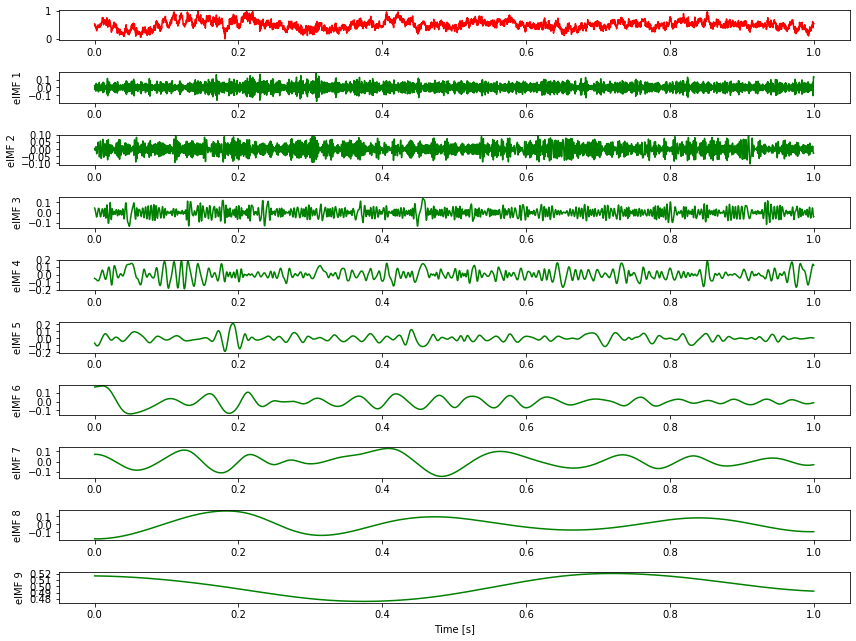

In [8]:

from PyEMD import EMD, EEMD
import numpy as np
s = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (0, +1))
eemd = EEMD()
#s = np.random.random(1001)

S = s
t = np.linspace(0, 1, 9501)
# Say we want detect extrema using parabolic method
import time
start = time.time()
emd = eemd.EMD
emd.extrema_detection="parabol"
eIMFs = EMD().emd(s,t)
#eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
stop = time.time()
print(stop-start)
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()

## Plot of spectral features across EMDs

In [9]:

df = pd.DataFrame()
i = 0
for e in eIMFs:
    eeg_data = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (-1, +1))
    i +=1
    [f,t] = computeFeatureCl(e, "SpectralCentroid", 1000)
    [f,t] = pyACA.computePitch('TimeAcf', e, 1000, afWindow=None, iBlockLength=1000, iHopLength=200)
    df[i] = np.squeeze(f)


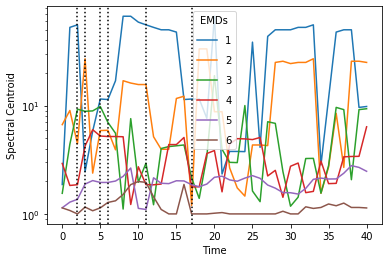

In [46]:
import seaborn as sbn
labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5', 'EMD6']
ax = sbn.lineplot(data=df.loc[0:40, 1:7], dashes = False)
ax.set(xlabel='Time', ylabel='Spectral Centroid')
ax.set_yscale('log')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'best')
colors = ['black','black','black','black','black','black','black','black','black','black', 'black','black', 'black','black']
for xc,c, l in zip(xposition,colors, labels):
    plt.axvline(x=xc, label='{} = {}'.format(l, xc), c=c, linestyle = 'dotted')
#plt.savefig('EMDs_spectral_flux_par_frontalR_1-5', dpi=120)

In [20]:
peaks_total.shape

(53, 5)

In [42]:

eIMFs_new = eIMFs[1:7]
df = pd.DataFrame()
i = 0
for e in eIMFs_new:
    i +=1
    #[f,t] = computeFeatureCl(e, "SpectralCentroid", 1000)
    [f,t] = pyACA.computePitch('TimeAcf', e, 1000, afWindow=None, iBlockLength=1000, iHopLength=200)
    df[i] = np.squeeze(f)

peaks_t = []
peaks_list = []
for t in range(len(df)):
    imf_temp = []
    for imf in range(df.shape[1]):
        imf = imf+1
        imf_temp.append(df.loc[t, imf])
    peaks_list.append(imf_temp) 
peaks_total = np.array(peaks_list) 

cons_tot = []
peaks_cons_temp = []
for peaks in peaks_total[0:40]:
    cons, peaks_cons = compute_consonance(peaks, 0.2)
    print(cons)
    peaks_cons_temp.append(peaks_cons)

xposition = []
for i in range(len(peaks_cons_temp)):
    if len(peaks_cons_temp[i]) != 0:
        xposition.append(i)
        


[]
[]
[0.8333333333333334, 0.5833333333333334]
[0.2159090909090909]
[]
[0.36666666666666664, 0.5333333333333333]
[0.20192307692307693, 0.2159090909090909]
[]
[]
[]
[]
[0.2361111111111111]
[]
[]
[]
[]
[]
[0.5833333333333334, 0.8333333333333334]
[]
[]
[]
[]
[]
[]
[0.25396825396825395]
[]
[0.5333333333333333, 0.36666666666666664]
[]
[]
[0.2361111111111111]
[]
[]
[]
[]
[]
[]
[0.45, 0.325]
[]
[]
[0.8333333333333334, 0.5833333333333334]


In [44]:
xposition

[2, 3, 5, 6, 11, 17, 24, 26, 29, 36, 39]

In [23]:
for i in range(len(peaks_cons_temp)):
    if len(peaks_cons_temp[i]) != 0:
        print('consonance')
        print(i)

consonance
1
consonance
2
consonance
3
consonance
4
consonance
5
consonance
7
consonance
8
consonance
9
consonance
10
consonance
15
consonance
16


Reading ../../pareidolia_run2.fif ...


<ipython-input-86-ae51f94a2fe9>:8: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


KeyError: 'Event "e" is not in Epochs. Event_ids must be one of "Image_on_nopar_low, Image_on_par_low, Image_on_nopar_mid, Image_on_par_mid, Image_on_nopar_high, Image_on_par_high"'

In [109]:
#Generate noise in specific frequency band#

def band_limited_noise(min_freq, max_freq, samples=44100, samplerate=44100):
    from functools import reduce
    t = np.linspace(0, samples/samplerate, samples)
    freqs = np.arange(min_freq, max_freq+1, samples/samplerate)
    phases = np.random.rand(len(freqs))*2*np.pi
    signals = [np.sin(2*np.pi*freq*t + phase) for freq,phase in zip(freqs,phases)]
    signal = reduce(lambda a,b: a+b,signals)
    signal /= np.max(signal)
    return signal

In [101]:
par

['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']

In [265]:
path = '../../pareidolia_run2.fif'
conditions = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low',
              'Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
input_data = ['eeg', 'noise']
method = 'SpectralCentroid'
mean_cons_trials_white = []
mean_cons_tot = []
for c in conditions:
    print(c)
    for i in input_data:
        mean_cons_trials_white.append(EMD_spectromorph_graph(path, method, condition = c, input_data=i))
        mean_cons_temp = np.array(mean_cons_trials_white)
    mean_cons_tot.append(mean_cons_temp)

Image_on_par_high
Reading ../../pareidolia_run2.fif ...


<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(16, 40, 7001)
peaks shape
(28, 6)
0
1
(16, 40, 7001)
peaks shape
(28, 6)
0
2
(16, 40, 7001)
peaks shape
(28, 6)
0
3
(16, 40, 7001)
peaks shape
(28, 6)
0
4
(16, 40, 7001)
peaks shape
(28, 6)
0
5
(16, 40, 7001)
peaks shape
(28, 6)
0
6
(16, 40, 7001)
peaks shape
(28, 6)
0
7
(16, 40, 7001)
peaks shape
(28, 6)
0
8
(16, 40, 7001)
peaks shape
(28, 6)
0
9
(16, 40, 7001)
peaks shape
(28, 6)
0
10
(16, 40, 7001)
peaks shape
(28, 6)
0
11
(16, 40, 7001)
peaks shape
(28, 6)
0
12
(16, 40, 7001)
peaks shape
(28, 6)
0
13
(16, 40, 7001)
peaks shape
(28, 6)
0
14
(16, 40, 7001)
peaks shape
(28, 6)
0
15
(16, 40, 7001)
peaks shape
(28, 6)
0
16
(16, 40, 7001)
peaks shape
(28, 6)
0
17
(16, 40, 7001)
peaks shape
(28, 6)
0
18
(16, 4

peaks shape
(28, 6)
5
0
(16, 40, 7001)
peaks shape
(28, 6)
5
1
(16, 40, 7001)
peaks shape
(28, 6)
5
2
(16, 40, 7001)
peaks shape
(28, 6)
5
3
(16, 40, 7001)
peaks shape
(28, 6)
5
4
(16, 40, 7001)
peaks shape
(28, 6)
5
5
(16, 40, 7001)
peaks shape
(28, 6)
5
6
(16, 40, 7001)
peaks shape
(28, 6)
5
7
(16, 40, 7001)
peaks shape
(28, 6)
5
8
(16, 40, 7001)
peaks shape
(28, 6)
5
9
(16, 40, 7001)
peaks shape
(28, 6)
5
10
(16, 40, 7001)
peaks shape
(28, 6)
5
11
(16, 40, 7001)
peaks shape
(28, 6)
5
12
(16, 40, 7001)
peaks shape
(28, 6)
5
13
(16, 40, 7001)
peaks shape
(28, 6)
5
14
(16, 40, 7001)
peaks shape
(28, 6)
5
15
(16, 40, 7001)
peaks shape
(28, 6)
5
16
(16, 40, 7001)
peaks shape
(28, 6)
5
17
(16, 40, 7001)
peaks shape
(28, 6)
5
18
(16, 40, 7001)
peaks shape
(28, 6)
5
19
(16, 40, 7001)
peaks shape
(28, 6)
5
20
(16, 40, 7001)
peaks shape
(28, 6)
5
21
(16, 40, 7001)
peaks shape
(28, 6)
5
22
(16, 40, 7001)
peaks shape
(28, 6)
5
23
(16, 40, 7001)
peaks shape
(28, 6)
5
24
(16, 40, 7001)
peaks shap

10
6
(16, 40, 7001)
peaks shape
(28, 6)
10
7
(16, 40, 7001)
peaks shape
(28, 6)
10
8
(16, 40, 7001)
peaks shape
(28, 6)
10
9
(16, 40, 7001)
peaks shape
(28, 6)
10
10
(16, 40, 7001)
peaks shape
(28, 6)
10
11
(16, 40, 7001)
peaks shape
(28, 6)
10
12
(16, 40, 7001)
peaks shape
(28, 6)
10
13
(16, 40, 7001)
peaks shape
(28, 6)
10
14
(16, 40, 7001)
peaks shape
(28, 6)
10
15
(16, 40, 7001)
peaks shape
(28, 6)
10
16
(16, 40, 7001)
peaks shape
(28, 6)
10
17
(16, 40, 7001)
peaks shape
(28, 6)
10
18
(16, 40, 7001)
peaks shape
(28, 6)
10
19
(16, 40, 7001)
peaks shape
(28, 6)
10
20
(16, 40, 7001)
peaks shape
(28, 6)
10
21
(16, 40, 7001)
peaks shape
(28, 6)
10
22
(16, 40, 7001)
peaks shape
(28, 6)
10
23
(16, 40, 7001)
peaks shape
(28, 6)
10
24
(16, 40, 7001)
peaks shape
(28, 6)
10
25
(16, 40, 7001)
peaks shape
(28, 6)
10
26
(16, 40, 7001)
peaks shape
(28, 6)
10
27
(16, 40, 7001)
peaks shape
(28, 6)
10
28
(16, 40, 7001)
peaks shape
(28, 6)
10
29
(16, 40, 7001)
peaks shape
(28, 6)
10
30
(16, 40, 7001)

peaks shape
(28, 6)
15
8
(16, 40, 7001)
peaks shape
(28, 6)
15
9
(16, 40, 7001)
peaks shape
(28, 6)
15
10
(16, 40, 7001)
peaks shape
(28, 6)
15
11
(16, 40, 7001)
peaks shape
(28, 6)
15
12
(16, 40, 7001)
peaks shape
(28, 6)
15
13
(16, 40, 7001)
peaks shape
(28, 6)
15
14
(16, 40, 7001)
peaks shape
(28, 6)
15
15
(16, 40, 7001)
peaks shape
(28, 6)
15
16
(16, 40, 7001)
peaks shape
(28, 6)
15
17
(16, 40, 7001)
peaks shape
(28, 6)
15
18
(16, 40, 7001)
peaks shape
(28, 6)
15
19
(16, 40, 7001)
peaks shape
(28, 6)
15
20
(16, 40, 7001)
peaks shape
(28, 6)
15
21
(16, 40, 7001)
peaks shape
(28, 6)
15
22
(16, 40, 7001)
peaks shape
(28, 6)
15
23
(16, 40, 7001)
peaks shape
(28, 6)
15
24
(16, 40, 7001)
peaks shape
(28, 6)
15
25
(16, 40, 7001)
peaks shape
(28, 6)
15
26
(16, 40, 7001)
peaks shape
(28, 6)
15
27
(16, 40, 7001)
peaks shape
(28, 6)
15
28
(16, 40, 7001)
peaks shape
(28, 6)
15
29
(16, 40, 7001)
peaks shape
(28, 6)
15
30
(16, 40, 7001)
peaks shape
(28, 6)
15
31
(16, 40, 7001)
peaks shape
(28, 6

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(16, 40, 7001)
peaks shape
(28, 6)
0
1
(16, 40, 7001)
peaks shape
(28, 6)
0
2
(16, 40, 7001)
peaks shape
(28, 6)
0
3
(16, 40, 7001)
peaks shape
(28, 6)
0
4
(16, 40, 7001)
peaks shape
(28, 6)
0
5
(16, 40, 7001)
peaks shape
(28, 6)
0
6
(16, 40, 7001)
peaks shape
(28, 6)
0
7
(16, 40, 7001)
peaks shape
(28, 6)
0
8
(16, 40, 7001)
peaks shape
(28, 6)
0
9
(16, 40, 7001)
peaks shape
(28, 6)
0
10
(16, 40, 7001)
peaks shape
(28, 6)
0
11
(16, 40, 7001)
peaks shape
(28, 6)
0
12
(16, 40, 7001)
peaks shape
(28, 6)
0
13
(16, 40, 7001)
peaks shape
(28, 6)
0
14
(16, 40, 7001)
peaks shape
(28, 6)
0
15
(16, 40, 7001)
peaks shape
(28, 6)
0
16
(16, 40, 7001)
peaks shape
(28, 6)
0
17
(16, 40, 7001)
peaks shape
(28, 6)
0
18
(16, 4

peaks shape
(28, 6)
5
0
(16, 40, 7001)
peaks shape
(28, 6)
5
1
(16, 40, 7001)
peaks shape
(28, 6)
5
2
(16, 40, 7001)
peaks shape
(28, 6)
5
3
(16, 40, 7001)
peaks shape
(28, 6)
5
4
(16, 40, 7001)
peaks shape
(28, 6)
5
5
(16, 40, 7001)
peaks shape
(28, 6)
5
6
(16, 40, 7001)
peaks shape
(28, 6)
5
7
(16, 40, 7001)
peaks shape
(28, 6)
5
8
(16, 40, 7001)
peaks shape
(28, 6)
5
9
(16, 40, 7001)
peaks shape
(28, 6)
5
10
(16, 40, 7001)
peaks shape
(28, 6)
5
11
(16, 40, 7001)
peaks shape
(28, 6)
5
12
(16, 40, 7001)
peaks shape
(28, 6)
5
13
(16, 40, 7001)
peaks shape
(28, 6)
5
14
(16, 40, 7001)
peaks shape
(28, 6)
5
15
(16, 40, 7001)
peaks shape
(28, 6)
5
16
(16, 40, 7001)
peaks shape
(28, 6)
5
17
(16, 40, 7001)
peaks shape
(28, 6)
5
18
(16, 40, 7001)
peaks shape
(28, 6)
5
19
(16, 40, 7001)
peaks shape
(28, 6)
5
20
(16, 40, 7001)
peaks shape
(28, 6)
5
21
(16, 40, 7001)
peaks shape
(28, 6)
5
22
(16, 40, 7001)
peaks shape
(28, 6)
5
23
(16, 40, 7001)
peaks shape
(28, 6)
5
24
(16, 40, 7001)
peaks shap

10
6
(16, 40, 7001)
peaks shape
(28, 6)
10
7
(16, 40, 7001)
peaks shape
(28, 6)
10
8
(16, 40, 7001)
peaks shape
(28, 6)
10
9
(16, 40, 7001)
peaks shape
(28, 6)
10
10
(16, 40, 7001)
peaks shape
(28, 6)
10
11
(16, 40, 7001)
peaks shape
(28, 6)
10
12
(16, 40, 7001)
peaks shape
(28, 6)
10
13
(16, 40, 7001)
peaks shape
(28, 6)
10
14
(16, 40, 7001)
peaks shape
(28, 6)
10
15
(16, 40, 7001)
peaks shape
(28, 6)
10
16
(16, 40, 7001)
peaks shape
(28, 6)
10
17
(16, 40, 7001)
peaks shape
(28, 6)
10
18
(16, 40, 7001)
peaks shape
(28, 6)
10
19
(16, 40, 7001)
peaks shape
(28, 6)
10
20
(16, 40, 7001)
peaks shape
(28, 6)
10
21
(16, 40, 7001)
peaks shape
(28, 6)
10
22
(16, 40, 7001)
peaks shape
(28, 6)
10
23
(16, 40, 7001)
peaks shape
(28, 6)
10
24
(16, 40, 7001)
peaks shape
(28, 6)
10
25
(16, 40, 7001)
peaks shape
(28, 6)
10
26
(16, 40, 7001)
peaks shape
(28, 6)
10
27
(16, 40, 7001)
peaks shape
(28, 6)
10
28
(16, 40, 7001)
peaks shape
(28, 6)
10
29
(16, 40, 7001)
peaks shape
(28, 6)
10
30
(16, 40, 7001)

peaks shape
(28, 6)
15
8
(16, 40, 7001)
peaks shape
(28, 6)
15
9
(16, 40, 7001)
peaks shape
(28, 6)
15
10
(16, 40, 7001)
peaks shape
(28, 6)
15
11
(16, 40, 7001)
peaks shape
(28, 6)
15
12
(16, 40, 7001)
peaks shape
(28, 6)
15
13
(16, 40, 7001)
peaks shape
(28, 6)
15
14
(16, 40, 7001)
peaks shape
(28, 6)
15
15
(16, 40, 7001)
peaks shape
(28, 6)
15
16
(16, 40, 7001)
peaks shape
(28, 6)
15
17
(16, 40, 7001)
peaks shape
(28, 6)
15
18
(16, 40, 7001)
peaks shape
(28, 6)
15
19
(16, 40, 7001)
peaks shape
(28, 6)
15
20
(16, 40, 7001)
peaks shape
(28, 6)
15
21
(16, 40, 7001)
peaks shape
(28, 6)
15
22
(16, 40, 7001)
peaks shape
(28, 6)
15
23
(16, 40, 7001)
peaks shape
(28, 6)
15
24
(16, 40, 7001)
peaks shape
(28, 6)
15
25
(16, 40, 7001)
peaks shape
(28, 6)
15
26
(16, 40, 7001)
peaks shape
(28, 6)
15
27
(16, 40, 7001)
peaks shape
(28, 6)
15
28
(16, 40, 7001)
peaks shape
(28, 6)
15
29
(16, 40, 7001)
peaks shape
(28, 6)
15
30
(16, 40, 7001)
peaks shape
(28, 6)
15
31
(16, 40, 7001)
peaks shape
(28, 6

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(22, 40, 7001)
peaks shape
(28, 6)
0
1
(22, 40, 7001)
peaks shape
(28, 6)
0
2
(22, 40, 7001)
peaks shape
(28, 6)
0
3
(22, 40, 7001)
peaks shape
(28, 6)
0
4
(22, 40, 7001)
peaks shape
(28, 6)
0
5
(22, 40, 7001)
peaks shape
(28, 6)
0
6
(22, 40, 7001)
peaks shape
(28, 6)
0
7
(22, 40, 7001)
peaks shape
(28, 6)
0
8
(22, 40, 7001)
peaks shape
(28, 6)
0
9
(22, 40, 7001)
peaks shape
(28, 6)
0
10
(22, 40, 7001)
peaks shape
(28, 6)
0
11
(22, 40, 7001)
peaks shape
(28, 6)
0
12
(22, 40, 7001)
peaks shape
(28, 6)
0
13
(22, 40, 7001)
peaks shape
(28, 6)
0
14
(22, 40, 7001)
peaks shape
(28, 6)
0
15
(22, 40, 7001)
peaks shape
(28, 6)
0
16
(22, 40, 7001)
peaks shape
(28, 6)
0
17
(22, 40, 7001)
peaks shape
(28, 6)
0
18
(22, 4

peaks shape
(28, 6)
5
0
(22, 40, 7001)
peaks shape
(28, 6)
5
1
(22, 40, 7001)
peaks shape
(28, 6)
5
2
(22, 40, 7001)
peaks shape
(28, 6)
5
3
(22, 40, 7001)
peaks shape
(28, 6)
5
4
(22, 40, 7001)
peaks shape
(28, 6)
5
5
(22, 40, 7001)
peaks shape
(28, 6)
5
6
(22, 40, 7001)
peaks shape
(28, 6)
5
7
(22, 40, 7001)
peaks shape
(28, 6)
5
8
(22, 40, 7001)
peaks shape
(28, 6)
5
9
(22, 40, 7001)
peaks shape
(28, 6)
5
10
(22, 40, 7001)
peaks shape
(28, 6)
5
11
(22, 40, 7001)
peaks shape
(28, 6)
5
12
(22, 40, 7001)
peaks shape
(28, 6)
5
13
(22, 40, 7001)
peaks shape
(28, 6)
5
14
(22, 40, 7001)
peaks shape
(28, 6)
5
15
(22, 40, 7001)
peaks shape
(28, 6)
5
16
(22, 40, 7001)
peaks shape
(28, 6)
5
17
(22, 40, 7001)
peaks shape
(28, 6)
5
18
(22, 40, 7001)
peaks shape
(28, 6)
5
19
(22, 40, 7001)
peaks shape
(28, 6)
5
20
(22, 40, 7001)
peaks shape
(28, 6)
5
21
(22, 40, 7001)
peaks shape
(28, 6)
5
22
(22, 40, 7001)
peaks shape
(28, 6)
5
23
(22, 40, 7001)
peaks shape
(28, 6)
5
24
(22, 40, 7001)
peaks shap

10
6
(22, 40, 7001)
peaks shape
(28, 6)
10
7
(22, 40, 7001)
peaks shape
(28, 6)
10
8
(22, 40, 7001)
peaks shape
(28, 6)
10
9
(22, 40, 7001)
peaks shape
(28, 6)
10
10
(22, 40, 7001)
peaks shape
(28, 6)
10
11
(22, 40, 7001)
peaks shape
(28, 6)
10
12
(22, 40, 7001)
peaks shape
(28, 6)
10
13
(22, 40, 7001)
peaks shape
(28, 6)
10
14
(22, 40, 7001)
peaks shape
(28, 6)
10
15
(22, 40, 7001)
peaks shape
(28, 6)
10
16
(22, 40, 7001)
peaks shape
(28, 6)
10
17
(22, 40, 7001)
peaks shape
(28, 6)
10
18
(22, 40, 7001)
peaks shape
(28, 6)
10
19
(22, 40, 7001)
peaks shape
(28, 6)
10
20
(22, 40, 7001)
peaks shape
(28, 6)
10
21
(22, 40, 7001)
peaks shape
(28, 6)
10
22
(22, 40, 7001)
peaks shape
(28, 6)
10
23
(22, 40, 7001)
peaks shape
(28, 6)
10
24
(22, 40, 7001)
peaks shape
(28, 6)
10
25
(22, 40, 7001)
peaks shape
(28, 6)
10
26
(22, 40, 7001)
peaks shape
(28, 6)
10
27
(22, 40, 7001)
peaks shape
(28, 6)
10
28
(22, 40, 7001)
peaks shape
(28, 6)
10
29
(22, 40, 7001)
peaks shape
(28, 6)
10
30
(22, 40, 7001)

peaks shape
(28, 6)
15
8
(22, 40, 7001)
peaks shape
(28, 6)
15
9
(22, 40, 7001)
peaks shape
(28, 6)
15
10
(22, 40, 7001)
peaks shape
(28, 6)
15
11
(22, 40, 7001)
peaks shape
(28, 6)
15
12
(22, 40, 7001)
peaks shape
(28, 6)
15
13
(22, 40, 7001)
peaks shape
(28, 6)
15
14
(22, 40, 7001)
peaks shape
(28, 6)
15
15
(22, 40, 7001)
peaks shape
(28, 6)
15
16
(22, 40, 7001)
peaks shape
(28, 6)
15
17
(22, 40, 7001)
peaks shape
(28, 6)
15
18
(22, 40, 7001)
peaks shape
(28, 6)
15
19
(22, 40, 7001)
peaks shape
(28, 6)
15
20
(22, 40, 7001)
peaks shape
(28, 6)
15
21
(22, 40, 7001)
peaks shape
(28, 6)
15
22
(22, 40, 7001)
peaks shape
(28, 6)
15
23
(22, 40, 7001)
peaks shape
(28, 6)
15
24
(22, 40, 7001)
peaks shape
(28, 6)
15
25
(22, 40, 7001)
peaks shape
(28, 6)
15
26
(22, 40, 7001)
peaks shape
(28, 6)
15
27
(22, 40, 7001)
peaks shape
(28, 6)
15
28
(22, 40, 7001)
peaks shape
(28, 6)
15
29
(22, 40, 7001)
peaks shape
(28, 6)
15
30
(22, 40, 7001)
peaks shape
(28, 6)
15
31
(22, 40, 7001)
peaks shape
(28, 6

20
9
(22, 40, 7001)
peaks shape
(28, 6)
20
10
(22, 40, 7001)
peaks shape
(28, 6)
20
11
(22, 40, 7001)
peaks shape
(28, 6)
20
12
(22, 40, 7001)
peaks shape
(28, 6)
20
13
(22, 40, 7001)
peaks shape
(28, 6)
20
14
(22, 40, 7001)
peaks shape
(28, 6)
20
15
(22, 40, 7001)
peaks shape
(28, 6)
20
16
(22, 40, 7001)
peaks shape
(28, 6)
20
17
(22, 40, 7001)
peaks shape
(28, 6)
20
18
(22, 40, 7001)
peaks shape
(28, 6)
20
19
(22, 40, 7001)
peaks shape
(28, 6)
20
20
(22, 40, 7001)
peaks shape
(28, 6)
20
21
(22, 40, 7001)
peaks shape
(28, 6)
20
22
(22, 40, 7001)
peaks shape
(28, 6)
20
23
(22, 40, 7001)
peaks shape
(28, 6)
20
24
(22, 40, 7001)
peaks shape
(28, 6)
20
25
(22, 40, 7001)
peaks shape
(28, 6)
20
26
(22, 40, 7001)
peaks shape
(28, 6)
20
27
(22, 40, 7001)
peaks shape
(28, 6)
20
28
(22, 40, 7001)
peaks shape
(28, 6)
20
29
(22, 40, 7001)
peaks shape
(28, 6)
20
30
(22, 40, 7001)
peaks shape
(28, 6)
20
31
(22, 40, 7001)
peaks shape
(28, 6)
20
32
(22, 40, 7001)
peaks shape
(28, 6)
20
33
(22, 40, 70

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(22, 40, 7001)
peaks shape
(28, 6)
0
1
(22, 40, 7001)
peaks shape
(28, 6)
0
2
(22, 40, 7001)
peaks shape
(28, 6)
0
3
(22, 40, 7001)
peaks shape
(28, 6)
0
4
(22, 40, 7001)
peaks shape
(28, 6)
0
5
(22, 40, 7001)
peaks shape
(28, 6)
0
6
(22, 40, 7001)
peaks shape
(28, 6)
0
7
(22, 40, 7001)
peaks shape
(28, 6)
0
8
(22, 40, 7001)
peaks shape
(28, 6)
0
9
(22, 40, 7001)
peaks shape
(28, 6)
0
10
(22, 40, 7001)
peaks shape
(28, 6)
0
11
(22, 40, 7001)
peaks shape
(28, 6)
0
12
(22, 40, 7001)
peaks shape
(28, 6)
0
13
(22, 40, 7001)
peaks shape
(28, 6)
0
14
(22, 40, 7001)
peaks shape
(28, 6)
0
15
(22, 40, 7001)
peaks shape
(28, 6)
0
16
(22, 40, 7001)
peaks shape
(28, 6)
0
17
(22, 40, 7001)
peaks shape
(28, 6)
0
18
(22, 4

peaks shape
(28, 6)
5
0
(22, 40, 7001)
peaks shape
(28, 6)
5
1
(22, 40, 7001)
peaks shape
(28, 6)
5
2
(22, 40, 7001)
peaks shape
(28, 6)
5
3
(22, 40, 7001)
peaks shape
(28, 6)
5
4
(22, 40, 7001)
peaks shape
(28, 6)
5
5
(22, 40, 7001)
peaks shape
(28, 6)
5
6
(22, 40, 7001)
peaks shape
(28, 6)
5
7
(22, 40, 7001)
peaks shape
(28, 6)
5
8
(22, 40, 7001)
peaks shape
(28, 6)
5
9
(22, 40, 7001)
peaks shape
(28, 6)
5
10
(22, 40, 7001)
peaks shape
(28, 6)
5
11
(22, 40, 7001)
peaks shape
(28, 6)
5
12
(22, 40, 7001)
peaks shape
(28, 6)
5
13
(22, 40, 7001)
peaks shape
(28, 6)
5
14
(22, 40, 7001)
peaks shape
(28, 6)
5
15
(22, 40, 7001)
peaks shape
(28, 6)
5
16
(22, 40, 7001)
peaks shape
(28, 6)
5
17
(22, 40, 7001)
peaks shape
(28, 6)
5
18
(22, 40, 7001)
peaks shape
(28, 6)
5
19
(22, 40, 7001)
peaks shape
(28, 6)
5
20
(22, 40, 7001)
peaks shape
(28, 6)
5
21
(22, 40, 7001)
peaks shape
(28, 6)
5
22
(22, 40, 7001)
peaks shape
(28, 6)
5
23
(22, 40, 7001)
peaks shape
(28, 6)
5
24
(22, 40, 7001)
peaks shap

10
6
(22, 40, 7001)
peaks shape
(28, 6)
10
7
(22, 40, 7001)
peaks shape
(28, 6)
10
8
(22, 40, 7001)
peaks shape
(28, 6)
10
9
(22, 40, 7001)
peaks shape
(28, 6)
10
10
(22, 40, 7001)
peaks shape
(28, 6)
10
11
(22, 40, 7001)
peaks shape
(28, 6)
10
12
(22, 40, 7001)
peaks shape
(28, 6)
10
13
(22, 40, 7001)
peaks shape
(28, 6)
10
14
(22, 40, 7001)
peaks shape
(28, 6)
10
15
(22, 40, 7001)
peaks shape
(28, 6)
10
16
(22, 40, 7001)
peaks shape
(28, 6)
10
17
(22, 40, 7001)
peaks shape
(28, 6)
10
18
(22, 40, 7001)
peaks shape
(28, 6)
10
19
(22, 40, 7001)
peaks shape
(28, 6)
10
20
(22, 40, 7001)
peaks shape
(28, 6)
10
21
(22, 40, 7001)
peaks shape
(28, 6)
10
22
(22, 40, 7001)
peaks shape
(28, 6)
10
23
(22, 40, 7001)
peaks shape
(28, 6)
10
24
(22, 40, 7001)
peaks shape
(28, 6)
10
25
(22, 40, 7001)
peaks shape
(28, 6)
10
26
(22, 40, 7001)
peaks shape
(28, 6)
10
27
(22, 40, 7001)
peaks shape
(28, 6)
10
28
(22, 40, 7001)
peaks shape
(28, 6)
10
29
(22, 40, 7001)
peaks shape
(28, 6)
10
30
(22, 40, 7001)

peaks shape
(28, 6)
15
8
(22, 40, 7001)
peaks shape
(28, 6)
15
9
(22, 40, 7001)
peaks shape
(28, 6)
15
10
(22, 40, 7001)
peaks shape
(28, 6)
15
11
(22, 40, 7001)
peaks shape
(28, 6)
15
12
(22, 40, 7001)
peaks shape
(28, 6)
15
13
(22, 40, 7001)
peaks shape
(28, 6)
15
14
(22, 40, 7001)
peaks shape
(28, 6)
15
15
(22, 40, 7001)
peaks shape
(28, 6)
15
16
(22, 40, 7001)
peaks shape
(28, 6)
15
17
(22, 40, 7001)
peaks shape
(28, 6)
15
18
(22, 40, 7001)
peaks shape
(28, 6)
15
19
(22, 40, 7001)
peaks shape
(28, 6)
15
20
(22, 40, 7001)
peaks shape
(28, 6)
15
21
(22, 40, 7001)
peaks shape
(28, 6)
15
22
(22, 40, 7001)
peaks shape
(28, 6)
15
23
(22, 40, 7001)
peaks shape
(28, 6)
15
24
(22, 40, 7001)
peaks shape
(28, 6)
15
25
(22, 40, 7001)
peaks shape
(28, 6)
15
26
(22, 40, 7001)
peaks shape
(28, 6)
15
27
(22, 40, 7001)
peaks shape
(28, 6)
15
28
(22, 40, 7001)
peaks shape
(28, 6)
15
29
(22, 40, 7001)
peaks shape
(28, 6)
15
30
(22, 40, 7001)
peaks shape
(28, 6)
15
31
(22, 40, 7001)
peaks shape
(28, 6

20
9
(22, 40, 7001)
peaks shape
(28, 6)
20
10
(22, 40, 7001)
peaks shape
(28, 6)
20
11
(22, 40, 7001)
peaks shape
(28, 6)
20
12
(22, 40, 7001)
peaks shape
(28, 6)
20
13
(22, 40, 7001)
peaks shape
(28, 6)
20
14
(22, 40, 7001)
peaks shape
(28, 6)
20
15
(22, 40, 7001)
peaks shape
(28, 6)
20
16
(22, 40, 7001)
peaks shape
(28, 6)
20
17
(22, 40, 7001)
peaks shape
(28, 6)
20
18
(22, 40, 7001)
peaks shape
(28, 6)
20
19
(22, 40, 7001)
peaks shape
(28, 6)
20
20
(22, 40, 7001)
peaks shape
(28, 6)
20
21
(22, 40, 7001)
peaks shape
(28, 6)
20
22
(22, 40, 7001)
peaks shape
(28, 6)
20
23
(22, 40, 7001)
peaks shape
(28, 6)
20
24
(22, 40, 7001)
peaks shape
(28, 6)
20
25
(22, 40, 7001)
peaks shape
(28, 6)
20
26
(22, 40, 7001)
peaks shape
(28, 6)
20
27
(22, 40, 7001)
peaks shape
(28, 6)
20
28
(22, 40, 7001)
peaks shape
(28, 6)
20
29
(22, 40, 7001)
peaks shape
(28, 6)
20
30
(22, 40, 7001)
peaks shape
(28, 6)
20
31
(22, 40, 7001)
peaks shape
(28, 6)
20
32
(22, 40, 7001)
peaks shape
(28, 6)
20
33
(22, 40, 70

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(20, 40, 7001)
peaks shape
(28, 6)
0
1
(20, 40, 7001)
peaks shape
(28, 6)
0
2
(20, 40, 7001)
peaks shape
(28, 6)
0
3
(20, 40, 7001)
peaks shape
(28, 6)
0
4
(20, 40, 7001)
peaks shape
(28, 6)
0
5
(20, 40, 7001)
peaks shape
(28, 6)
0
6
(20, 40, 7001)
peaks shape
(28, 6)
0
7
(20, 40, 7001)
peaks shape
(28, 6)
0
8
(20, 40, 7001)
peaks shape
(28, 6)
0
9
(20, 40, 7001)
peaks shape
(28, 6)
0
10
(20, 40, 7001)
peaks shape
(28, 6)
0
11
(20, 40, 7001)
peaks shape
(28, 6)
0
12
(20, 40, 7001)
peaks shape
(28, 6)
0
13
(20, 40, 7001)
peaks shape
(28, 6)
0
14
(20, 40, 7001)
peaks shape
(28, 6)
0
15
(20, 40, 7001)
peaks shape
(28, 6)
0
16
(20, 40, 7001)
peaks shape
(28, 6)
0
17
(20, 40, 7001)
peaks shape
(28, 6)
0
18
(20, 4

peaks shape
(28, 6)
5
0
(20, 40, 7001)
peaks shape
(28, 6)
5
1
(20, 40, 7001)
peaks shape
(28, 6)
5
2
(20, 40, 7001)
peaks shape
(28, 6)
5
3
(20, 40, 7001)
peaks shape
(28, 6)
5
4
(20, 40, 7001)
peaks shape
(28, 6)
5
5
(20, 40, 7001)
peaks shape
(28, 6)
5
6
(20, 40, 7001)
peaks shape
(28, 6)
5
7
(20, 40, 7001)
peaks shape
(28, 6)
5
8
(20, 40, 7001)
peaks shape
(28, 6)
5
9
(20, 40, 7001)
peaks shape
(28, 6)
5
10
(20, 40, 7001)
peaks shape
(28, 6)
5
11
(20, 40, 7001)
peaks shape
(28, 6)
5
12
(20, 40, 7001)
peaks shape
(28, 6)
5
13
(20, 40, 7001)
peaks shape
(28, 6)
5
14
(20, 40, 7001)
peaks shape
(28, 6)
5
15
(20, 40, 7001)
peaks shape
(28, 6)
5
16
(20, 40, 7001)
peaks shape
(28, 6)
5
17
(20, 40, 7001)
peaks shape
(28, 6)
5
18
(20, 40, 7001)
peaks shape
(28, 6)
5
19
(20, 40, 7001)
peaks shape
(28, 6)
5
20
(20, 40, 7001)
peaks shape
(28, 6)
5
21
(20, 40, 7001)
peaks shape
(28, 6)
5
22
(20, 40, 7001)
peaks shape
(28, 6)
5
23
(20, 40, 7001)
peaks shape
(28, 6)
5
24
(20, 40, 7001)
peaks shap

10
6
(20, 40, 7001)
peaks shape
(28, 6)
10
7
(20, 40, 7001)
peaks shape
(28, 6)
10
8
(20, 40, 7001)
peaks shape
(28, 6)
10
9
(20, 40, 7001)
peaks shape
(28, 6)
10
10
(20, 40, 7001)
peaks shape
(28, 6)
10
11
(20, 40, 7001)
peaks shape
(28, 6)
10
12
(20, 40, 7001)
peaks shape
(28, 6)
10
13
(20, 40, 7001)
peaks shape
(28, 6)
10
14
(20, 40, 7001)
peaks shape
(28, 6)
10
15
(20, 40, 7001)
peaks shape
(28, 6)
10
16
(20, 40, 7001)
peaks shape
(28, 6)
10
17
(20, 40, 7001)
peaks shape
(28, 6)
10
18
(20, 40, 7001)
peaks shape
(28, 6)
10
19
(20, 40, 7001)
peaks shape
(28, 6)
10
20
(20, 40, 7001)
peaks shape
(28, 6)
10
21
(20, 40, 7001)
peaks shape
(28, 6)
10
22
(20, 40, 7001)
peaks shape
(28, 6)
10
23
(20, 40, 7001)
peaks shape
(28, 6)
10
24
(20, 40, 7001)
peaks shape
(28, 6)
10
25
(20, 40, 7001)
peaks shape
(28, 6)
10
26
(20, 40, 7001)
peaks shape
(28, 6)
10
27
(20, 40, 7001)
peaks shape
(28, 6)
10
28
(20, 40, 7001)
peaks shape
(28, 6)
10
29
(20, 40, 7001)
peaks shape
(28, 6)
10
30
(20, 40, 7001)

peaks shape
(28, 6)
15
8
(20, 40, 7001)
peaks shape
(28, 6)
15
9
(20, 40, 7001)
peaks shape
(28, 6)
15
10
(20, 40, 7001)
peaks shape
(28, 6)
15
11
(20, 40, 7001)
peaks shape
(28, 6)
15
12
(20, 40, 7001)
peaks shape
(28, 6)
15
13
(20, 40, 7001)
peaks shape
(28, 6)
15
14
(20, 40, 7001)
peaks shape
(28, 6)
15
15
(20, 40, 7001)
peaks shape
(28, 6)
15
16
(20, 40, 7001)
peaks shape
(28, 6)
15
17
(20, 40, 7001)
peaks shape
(28, 6)
15
18
(20, 40, 7001)
peaks shape
(28, 6)
15
19
(20, 40, 7001)
peaks shape
(28, 6)
15
20
(20, 40, 7001)
peaks shape
(28, 6)
15
21
(20, 40, 7001)
peaks shape
(28, 6)
15
22
(20, 40, 7001)
peaks shape
(28, 6)
15
23
(20, 40, 7001)
peaks shape
(28, 6)
15
24
(20, 40, 7001)
peaks shape
(28, 6)
15
25
(20, 40, 7001)
peaks shape
(28, 6)
15
26
(20, 40, 7001)
peaks shape
(28, 6)
15
27
(20, 40, 7001)
peaks shape
(28, 6)
15
28
(20, 40, 7001)
peaks shape
(28, 6)
15
29
(20, 40, 7001)
peaks shape
(28, 6)
15
30
(20, 40, 7001)
peaks shape
(28, 6)
15
31
(20, 40, 7001)
peaks shape
(28, 6

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(20, 40, 7001)
peaks shape
(28, 6)
0
1
(20, 40, 7001)
peaks shape
(28, 6)
0
2
(20, 40, 7001)
peaks shape
(28, 6)
0
3
(20, 40, 7001)
peaks shape
(28, 6)
0
4
(20, 40, 7001)
peaks shape
(28, 6)
0
5
(20, 40, 7001)
peaks shape
(28, 6)
0
6
(20, 40, 7001)
peaks shape
(28, 6)
0
7
(20, 40, 7001)
peaks shape
(28, 6)
0
8
(20, 40, 7001)
peaks shape
(28, 6)
0
9
(20, 40, 7001)
peaks shape
(28, 6)
0
10
(20, 40, 7001)
peaks shape
(28, 6)
0
11
(20, 40, 7001)
peaks shape
(28, 6)
0
12
(20, 40, 7001)
peaks shape
(28, 6)
0
13
(20, 40, 7001)
peaks shape
(28, 6)
0
14
(20, 40, 7001)
peaks shape
(28, 6)
0
15
(20, 40, 7001)
peaks shape
(28, 6)
0
16
(20, 40, 7001)
peaks shape
(28, 6)
0
17
(20, 40, 7001)
peaks shape
(28, 6)
0
18
(20, 4

peaks shape
(28, 6)
5
0
(20, 40, 7001)
peaks shape
(28, 6)
5
1
(20, 40, 7001)
peaks shape
(28, 6)
5
2
(20, 40, 7001)
peaks shape
(28, 6)
5
3
(20, 40, 7001)
peaks shape
(28, 6)
5
4
(20, 40, 7001)
peaks shape
(28, 6)
5
5
(20, 40, 7001)
peaks shape
(28, 6)
5
6
(20, 40, 7001)
peaks shape
(28, 6)
5
7
(20, 40, 7001)
peaks shape
(28, 6)
5
8
(20, 40, 7001)
peaks shape
(28, 6)
5
9
(20, 40, 7001)
peaks shape
(28, 6)
5
10
(20, 40, 7001)
peaks shape
(28, 6)
5
11
(20, 40, 7001)
peaks shape
(28, 6)
5
12
(20, 40, 7001)
peaks shape
(28, 6)
5
13
(20, 40, 7001)
peaks shape
(28, 6)
5
14
(20, 40, 7001)
peaks shape
(28, 6)
5
15
(20, 40, 7001)
peaks shape
(28, 6)
5
16
(20, 40, 7001)
peaks shape
(28, 6)
5
17
(20, 40, 7001)
peaks shape
(28, 6)
5
18
(20, 40, 7001)
peaks shape
(28, 6)
5
19
(20, 40, 7001)
peaks shape
(28, 6)
5
20
(20, 40, 7001)
peaks shape
(28, 6)
5
21
(20, 40, 7001)
peaks shape
(28, 6)
5
22
(20, 40, 7001)
peaks shape
(28, 6)
5
23
(20, 40, 7001)
peaks shape
(28, 6)
5
24
(20, 40, 7001)
peaks shap

10
6
(20, 40, 7001)
peaks shape
(28, 6)
10
7
(20, 40, 7001)
peaks shape
(28, 6)
10
8
(20, 40, 7001)
peaks shape
(28, 6)
10
9
(20, 40, 7001)
peaks shape
(28, 6)
10
10
(20, 40, 7001)
peaks shape
(28, 6)
10
11
(20, 40, 7001)
peaks shape
(28, 6)
10
12
(20, 40, 7001)
peaks shape
(28, 6)
10
13
(20, 40, 7001)
peaks shape
(28, 6)
10
14
(20, 40, 7001)
peaks shape
(28, 6)
10
15
(20, 40, 7001)
peaks shape
(28, 6)
10
16
(20, 40, 7001)
peaks shape
(28, 6)
10
17
(20, 40, 7001)
peaks shape
(28, 6)
10
18
(20, 40, 7001)
peaks shape
(28, 6)
10
19
(20, 40, 7001)
peaks shape
(28, 6)
10
20
(20, 40, 7001)
peaks shape
(28, 6)
10
21
(20, 40, 7001)
peaks shape
(28, 6)
10
22
(20, 40, 7001)
peaks shape
(28, 6)
10
23
(20, 40, 7001)
peaks shape
(28, 6)
10
24
(20, 40, 7001)
peaks shape
(28, 6)
10
25
(20, 40, 7001)
peaks shape
(28, 6)
10
26
(20, 40, 7001)
peaks shape
(28, 6)
10
27
(20, 40, 7001)
peaks shape
(28, 6)
10
28
(20, 40, 7001)
peaks shape
(28, 6)
10
29
(20, 40, 7001)
peaks shape
(28, 6)
10
30
(20, 40, 7001)

peaks shape
(28, 6)
15
8
(20, 40, 7001)
peaks shape
(28, 6)
15
9
(20, 40, 7001)
peaks shape
(28, 6)
15
10
(20, 40, 7001)
peaks shape
(28, 6)
15
11
(20, 40, 7001)
peaks shape
(28, 6)
15
12
(20, 40, 7001)
peaks shape
(28, 6)
15
13
(20, 40, 7001)
peaks shape
(28, 6)
15
14
(20, 40, 7001)
peaks shape
(28, 6)
15
15
(20, 40, 7001)
peaks shape
(28, 6)
15
16
(20, 40, 7001)
peaks shape
(28, 6)
15
17
(20, 40, 7001)
peaks shape
(28, 6)
15
18
(20, 40, 7001)
peaks shape
(28, 6)
15
19
(20, 40, 7001)
peaks shape
(28, 6)
15
20
(20, 40, 7001)
peaks shape
(28, 6)
15
21
(20, 40, 7001)
peaks shape
(28, 6)
15
22
(20, 40, 7001)
peaks shape
(28, 6)
15
23
(20, 40, 7001)
peaks shape
(28, 6)
15
24
(20, 40, 7001)
peaks shape
(28, 6)
15
25
(20, 40, 7001)
peaks shape
(28, 6)
15
26
(20, 40, 7001)
peaks shape
(28, 6)
15
27
(20, 40, 7001)
peaks shape
(28, 6)
15
28
(20, 40, 7001)
peaks shape
(28, 6)
15
29
(20, 40, 7001)
peaks shape
(28, 6)
15
30
(20, 40, 7001)
peaks shape
(28, 6)
15
31
(20, 40, 7001)
peaks shape
(28, 6

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(24, 40, 7001)
peaks shape
(28, 6)
0
1
(24, 40, 7001)
peaks shape
(28, 6)
0
2
(24, 40, 7001)
peaks shape
(28, 6)
0
3
(24, 40, 7001)
peaks shape
(28, 6)
0
4
(24, 40, 7001)
peaks shape
(28, 6)
0
5
(24, 40, 7001)
peaks shape
(28, 6)
0
6
(24, 40, 7001)
peaks shape
(28, 6)
0
7
(24, 40, 7001)
peaks shape
(28, 6)
0
8
(24, 40, 7001)
peaks shape
(28, 6)
0
9
(24, 40, 7001)
peaks shape
(28, 6)
0
10
(24, 40, 7001)
peaks shape
(28, 6)
0
11
(24, 40, 7001)
peaks shape
(28, 6)
0
12
(24, 40, 7001)
peaks shape
(28, 6)
0
13
(24, 40, 7001)
peaks shape
(28, 6)
0
14
(24, 40, 7001)
peaks shape
(28, 6)
0
15
(24, 40, 7001)
peaks shape
(28, 6)
0
16
(24, 40, 7001)
peaks shape
(28, 6)
0
17
(24, 40, 7001)
peaks shape
(28, 6)
0
18
(24, 4

peaks shape
(28, 6)
5
0
(24, 40, 7001)
peaks shape
(28, 6)
5
1
(24, 40, 7001)
peaks shape
(28, 6)
5
2
(24, 40, 7001)
peaks shape
(28, 6)
5
3
(24, 40, 7001)
peaks shape
(28, 6)
5
4
(24, 40, 7001)
peaks shape
(28, 6)
5
5
(24, 40, 7001)
peaks shape
(28, 6)
5
6
(24, 40, 7001)
peaks shape
(28, 6)
5
7
(24, 40, 7001)
peaks shape
(28, 6)
5
8
(24, 40, 7001)
peaks shape
(28, 6)
5
9
(24, 40, 7001)
peaks shape
(28, 6)
5
10
(24, 40, 7001)
peaks shape
(28, 6)
5
11
(24, 40, 7001)
peaks shape
(28, 6)
5
12
(24, 40, 7001)
peaks shape
(28, 6)
5
13
(24, 40, 7001)
peaks shape
(28, 6)
5
14
(24, 40, 7001)
peaks shape
(28, 6)
5
15
(24, 40, 7001)
peaks shape
(28, 6)
5
16
(24, 40, 7001)
peaks shape
(28, 6)
5
17
(24, 40, 7001)
peaks shape
(28, 6)
5
18
(24, 40, 7001)
peaks shape
(28, 6)
5
19
(24, 40, 7001)
peaks shape
(28, 6)
5
20
(24, 40, 7001)
peaks shape
(28, 6)
5
21
(24, 40, 7001)
peaks shape
(28, 6)
5
22
(24, 40, 7001)
peaks shape
(28, 6)
5
23
(24, 40, 7001)
peaks shape
(28, 6)
5
24
(24, 40, 7001)
peaks shap

10
6
(24, 40, 7001)
peaks shape
(28, 6)
10
7
(24, 40, 7001)
peaks shape
(28, 6)
10
8
(24, 40, 7001)
peaks shape
(28, 6)
10
9
(24, 40, 7001)
peaks shape
(28, 6)
10
10
(24, 40, 7001)
peaks shape
(28, 6)
10
11
(24, 40, 7001)
peaks shape
(28, 6)
10
12
(24, 40, 7001)
peaks shape
(28, 6)
10
13
(24, 40, 7001)
peaks shape
(28, 6)
10
14
(24, 40, 7001)
peaks shape
(28, 6)
10
15
(24, 40, 7001)
peaks shape
(28, 6)
10
16
(24, 40, 7001)
peaks shape
(28, 6)
10
17
(24, 40, 7001)
peaks shape
(28, 6)
10
18
(24, 40, 7001)
peaks shape
(28, 6)
10
19
(24, 40, 7001)
peaks shape
(28, 6)
10
20
(24, 40, 7001)
peaks shape
(28, 6)
10
21
(24, 40, 7001)
peaks shape
(28, 6)
10
22
(24, 40, 7001)
peaks shape
(28, 6)
10
23
(24, 40, 7001)
peaks shape
(28, 6)
10
24
(24, 40, 7001)
peaks shape
(28, 6)
10
25
(24, 40, 7001)
peaks shape
(28, 6)
10
26
(24, 40, 7001)
peaks shape
(28, 6)
10
27
(24, 40, 7001)
peaks shape
(28, 6)
10
28
(24, 40, 7001)
peaks shape
(28, 6)
10
29
(24, 40, 7001)
peaks shape
(28, 6)
10
30
(24, 40, 7001)

peaks shape
(28, 6)
15
8
(24, 40, 7001)
peaks shape
(28, 6)
15
9
(24, 40, 7001)
peaks shape
(28, 6)
15
10
(24, 40, 7001)
peaks shape
(28, 6)
15
11
(24, 40, 7001)
peaks shape
(28, 6)
15
12
(24, 40, 7001)
peaks shape
(28, 6)
15
13
(24, 40, 7001)
peaks shape
(28, 6)
15
14
(24, 40, 7001)
peaks shape
(28, 6)
15
15
(24, 40, 7001)
peaks shape
(28, 6)
15
16
(24, 40, 7001)
peaks shape
(28, 6)
15
17
(24, 40, 7001)
peaks shape
(28, 6)
15
18
(24, 40, 7001)
peaks shape
(28, 6)
15
19
(24, 40, 7001)
peaks shape
(28, 6)
15
20
(24, 40, 7001)
peaks shape
(28, 6)
15
21
(24, 40, 7001)
peaks shape
(28, 6)
15
22
(24, 40, 7001)
peaks shape
(28, 6)
15
23
(24, 40, 7001)
peaks shape
(28, 6)
15
24
(24, 40, 7001)
peaks shape
(28, 6)
15
25
(24, 40, 7001)
peaks shape
(28, 6)
15
26
(24, 40, 7001)
peaks shape
(28, 6)
15
27
(24, 40, 7001)
peaks shape
(28, 6)
15
28
(24, 40, 7001)
peaks shape
(28, 6)
15
29
(24, 40, 7001)
peaks shape
(28, 6)
15
30
(24, 40, 7001)
peaks shape
(28, 6)
15
31
(24, 40, 7001)
peaks shape
(28, 6

20
9
(24, 40, 7001)
peaks shape
(28, 6)
20
10
(24, 40, 7001)
peaks shape
(28, 6)
20
11
(24, 40, 7001)
peaks shape
(28, 6)
20
12
(24, 40, 7001)
peaks shape
(28, 6)
20
13
(24, 40, 7001)
peaks shape
(28, 6)
20
14
(24, 40, 7001)
peaks shape
(28, 6)
20
15
(24, 40, 7001)
peaks shape
(28, 6)
20
16
(24, 40, 7001)
peaks shape
(28, 6)
20
17
(24, 40, 7001)
peaks shape
(28, 6)
20
18
(24, 40, 7001)
peaks shape
(28, 6)
20
19
(24, 40, 7001)
peaks shape
(28, 6)
20
20
(24, 40, 7001)
peaks shape
(28, 6)
20
21
(24, 40, 7001)
peaks shape
(28, 6)
20
22
(24, 40, 7001)
peaks shape
(28, 6)
20
23
(24, 40, 7001)
peaks shape
(28, 6)
20
24
(24, 40, 7001)
peaks shape
(28, 6)
20
25
(24, 40, 7001)
peaks shape
(28, 6)
20
26
(24, 40, 7001)
peaks shape
(28, 6)
20
27
(24, 40, 7001)
peaks shape
(28, 6)
20
28
(24, 40, 7001)
peaks shape
(28, 6)
20
29
(24, 40, 7001)
peaks shape
(28, 6)
20
30
(24, 40, 7001)
peaks shape
(28, 6)
20
31
(24, 40, 7001)
peaks shape
(28, 6)
20
32
(24, 40, 7001)
peaks shape
(28, 6)
20
33
(24, 40, 70

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(24, 40, 7001)
peaks shape
(28, 6)
0
1
(24, 40, 7001)
peaks shape
(28, 6)
0
2
(24, 40, 7001)
peaks shape
(28, 6)
0
3
(24, 40, 7001)
peaks shape
(28, 6)
0
4
(24, 40, 7001)
peaks shape
(28, 6)
0
5
(24, 40, 7001)
peaks shape
(28, 6)
0
6
(24, 40, 7001)
peaks shape
(28, 6)
0
7
(24, 40, 7001)
peaks shape
(28, 6)
0
8
(24, 40, 7001)
peaks shape
(28, 6)
0
9
(24, 40, 7001)
peaks shape
(28, 6)
0
10
(24, 40, 7001)
peaks shape
(28, 6)
0
11
(24, 40, 7001)
peaks shape
(28, 6)
0
12
(24, 40, 7001)
peaks shape
(28, 6)
0
13
(24, 40, 7001)
peaks shape
(28, 6)
0
14
(24, 40, 7001)
peaks shape
(28, 6)
0
15
(24, 40, 7001)
peaks shape
(28, 6)
0
16
(24, 40, 7001)
peaks shape
(28, 6)
0
17
(24, 40, 7001)
peaks shape
(28, 6)
0
18
(24, 4

peaks shape
(28, 6)
5
0
(24, 40, 7001)
peaks shape
(28, 6)
5
1
(24, 40, 7001)
peaks shape
(28, 6)
5
2
(24, 40, 7001)
peaks shape
(28, 6)
5
3
(24, 40, 7001)
peaks shape
(28, 6)
5
4
(24, 40, 7001)
peaks shape
(28, 6)
5
5
(24, 40, 7001)
peaks shape
(28, 6)
5
6
(24, 40, 7001)
peaks shape
(28, 6)
5
7
(24, 40, 7001)
peaks shape
(28, 6)
5
8
(24, 40, 7001)
peaks shape
(28, 6)
5
9
(24, 40, 7001)
peaks shape
(28, 6)
5
10
(24, 40, 7001)
peaks shape
(28, 6)
5
11
(24, 40, 7001)
peaks shape
(28, 6)
5
12
(24, 40, 7001)
peaks shape
(28, 6)
5
13
(24, 40, 7001)
peaks shape
(28, 6)
5
14
(24, 40, 7001)
peaks shape
(28, 6)
5
15
(24, 40, 7001)
peaks shape
(28, 6)
5
16
(24, 40, 7001)
peaks shape
(28, 6)
5
17
(24, 40, 7001)
peaks shape
(28, 6)
5
18
(24, 40, 7001)
peaks shape
(28, 6)
5
19
(24, 40, 7001)
peaks shape
(28, 6)
5
20
(24, 40, 7001)
peaks shape
(28, 6)
5
21
(24, 40, 7001)
peaks shape
(28, 6)
5
22
(24, 40, 7001)
peaks shape
(28, 6)
5
23
(24, 40, 7001)
peaks shape
(28, 6)
5
24
(24, 40, 7001)
peaks shap

10
6
(24, 40, 7001)
peaks shape
(28, 6)
10
7
(24, 40, 7001)
peaks shape
(28, 6)
10
8
(24, 40, 7001)
peaks shape
(28, 6)
10
9
(24, 40, 7001)
peaks shape
(28, 6)
10
10
(24, 40, 7001)
peaks shape
(28, 6)
10
11
(24, 40, 7001)
peaks shape
(28, 6)
10
12
(24, 40, 7001)
peaks shape
(28, 6)
10
13
(24, 40, 7001)
peaks shape
(28, 6)
10
14
(24, 40, 7001)
peaks shape
(28, 6)
10
15
(24, 40, 7001)
peaks shape
(28, 6)
10
16
(24, 40, 7001)
peaks shape
(28, 6)
10
17
(24, 40, 7001)
peaks shape
(28, 6)
10
18
(24, 40, 7001)
peaks shape
(28, 6)
10
19
(24, 40, 7001)
peaks shape
(28, 6)
10
20
(24, 40, 7001)
peaks shape
(28, 6)
10
21
(24, 40, 7001)
peaks shape
(28, 6)
10
22
(24, 40, 7001)
peaks shape
(28, 6)
10
23
(24, 40, 7001)
peaks shape
(28, 6)
10
24
(24, 40, 7001)
peaks shape
(28, 6)
10
25
(24, 40, 7001)
peaks shape
(28, 6)
10
26
(24, 40, 7001)
peaks shape
(28, 6)
10
27
(24, 40, 7001)
peaks shape
(28, 6)
10
28
(24, 40, 7001)
peaks shape
(28, 6)
10
29
(24, 40, 7001)
peaks shape
(28, 6)
10
30
(24, 40, 7001)

peaks shape
(28, 6)
15
8
(24, 40, 7001)
peaks shape
(28, 6)
15
9
(24, 40, 7001)
peaks shape
(28, 6)
15
10
(24, 40, 7001)
peaks shape
(28, 6)
15
11
(24, 40, 7001)
peaks shape
(28, 6)
15
12
(24, 40, 7001)
peaks shape
(28, 6)
15
13
(24, 40, 7001)
peaks shape
(28, 6)
15
14
(24, 40, 7001)
peaks shape
(28, 6)
15
15
(24, 40, 7001)
peaks shape
(28, 6)
15
16
(24, 40, 7001)
peaks shape
(28, 6)
15
17
(24, 40, 7001)
peaks shape
(28, 6)
15
18
(24, 40, 7001)
peaks shape
(28, 6)
15
19
(24, 40, 7001)
peaks shape
(28, 6)
15
20
(24, 40, 7001)
peaks shape
(28, 6)
15
21
(24, 40, 7001)
peaks shape
(28, 6)
15
22
(24, 40, 7001)
peaks shape
(28, 6)
15
23
(24, 40, 7001)
peaks shape
(28, 6)
15
24
(24, 40, 7001)
peaks shape
(28, 6)
15
25
(24, 40, 7001)
peaks shape
(28, 6)
15
26
(24, 40, 7001)
peaks shape
(28, 6)
15
27
(24, 40, 7001)
peaks shape
(28, 6)
15
28
(24, 40, 7001)
peaks shape
(28, 6)
15
29
(24, 40, 7001)
peaks shape
(28, 6)
15
30
(24, 40, 7001)
peaks shape
(28, 6)
15
31
(24, 40, 7001)
peaks shape
(28, 6

20
9
(24, 40, 7001)
peaks shape
(28, 6)
20
10
(24, 40, 7001)
peaks shape
(28, 6)
20
11
(24, 40, 7001)
peaks shape
(28, 6)
20
12
(24, 40, 7001)
peaks shape
(28, 6)
20
13
(24, 40, 7001)
peaks shape
(28, 6)
20
14
(24, 40, 7001)
peaks shape
(28, 6)
20
15
(24, 40, 7001)
peaks shape
(28, 6)
20
16
(24, 40, 7001)
peaks shape
(28, 6)
20
17
(24, 40, 7001)
peaks shape
(28, 6)
20
18
(24, 40, 7001)
peaks shape
(28, 6)
20
19
(24, 40, 7001)
peaks shape
(28, 6)
20
20
(24, 40, 7001)
peaks shape
(28, 6)
20
21
(24, 40, 7001)
peaks shape
(28, 6)
20
22
(24, 40, 7001)
peaks shape
(28, 6)
20
23
(24, 40, 7001)
peaks shape
(28, 6)
20
24
(24, 40, 7001)
peaks shape
(28, 6)
20
25
(24, 40, 7001)
peaks shape
(28, 6)
20
26
(24, 40, 7001)
peaks shape
(28, 6)
20
27
(24, 40, 7001)
peaks shape
(28, 6)
20
28
(24, 40, 7001)
peaks shape
(28, 6)
20
29
(24, 40, 7001)
peaks shape
(28, 6)
20
30
(24, 40, 7001)
peaks shape
(28, 6)
20
31
(24, 40, 7001)
peaks shape
(28, 6)
20
32
(24, 40, 7001)
peaks shape
(28, 6)
20
33
(24, 40, 70

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(10, 40, 7001)
peaks shape
(28, 6)
0
1
(10, 40, 7001)
peaks shape
(28, 6)
0
2
(10, 40, 7001)
peaks shape
(28, 6)
0
3
(10, 40, 7001)
peaks shape
(28, 6)
0
4
(10, 40, 7001)
peaks shape
(28, 6)
0
5
(10, 40, 7001)
peaks shape
(28, 6)
0
6
(10, 40, 7001)
peaks shape
(28, 6)
0
7
(10, 40, 7001)
peaks shape
(28, 6)
0
8
(10, 40, 7001)
peaks shape
(28, 6)
0
9
(10, 40, 7001)
peaks shape
(28, 6)
0
10
(10, 40, 7001)
peaks shape
(28, 6)
0
11
(10, 40, 7001)
peaks shape
(28, 6)
0
12
(10, 40, 7001)
peaks shape
(28, 6)
0
13
(10, 40, 7001)
peaks shape
(28, 6)
0
14
(10, 40, 7001)
peaks shape
(28, 6)
0
15
(10, 40, 7001)
peaks shape
(28, 6)
0
16
(10, 40, 7001)
peaks shape
(28, 6)
0
17
(10, 40, 7001)
peaks shape
(28, 6)
0
18
(10, 4

peaks shape
(28, 6)
5
0
(10, 40, 7001)
peaks shape
(28, 6)
5
1
(10, 40, 7001)
peaks shape
(28, 6)
5
2
(10, 40, 7001)
peaks shape
(28, 6)
5
3
(10, 40, 7001)
peaks shape
(28, 6)
5
4
(10, 40, 7001)
peaks shape
(28, 6)
5
5
(10, 40, 7001)
peaks shape
(28, 6)
5
6
(10, 40, 7001)
peaks shape
(28, 6)
5
7
(10, 40, 7001)
peaks shape
(28, 6)
5
8
(10, 40, 7001)
peaks shape
(28, 6)
5
9
(10, 40, 7001)
peaks shape
(28, 6)
5
10
(10, 40, 7001)
peaks shape
(28, 6)
5
11
(10, 40, 7001)
peaks shape
(28, 6)
5
12
(10, 40, 7001)
peaks shape
(28, 6)
5
13
(10, 40, 7001)
peaks shape
(28, 6)
5
14
(10, 40, 7001)
peaks shape
(28, 6)
5
15
(10, 40, 7001)
peaks shape
(28, 6)
5
16
(10, 40, 7001)
peaks shape
(28, 6)
5
17
(10, 40, 7001)
peaks shape
(28, 6)
5
18
(10, 40, 7001)
peaks shape
(28, 6)
5
19
(10, 40, 7001)
peaks shape
(28, 6)
5
20
(10, 40, 7001)
peaks shape
(28, 6)
5
21
(10, 40, 7001)
peaks shape
(28, 6)
5
22
(10, 40, 7001)
peaks shape
(28, 6)
5
23
(10, 40, 7001)
peaks shape
(28, 6)
5
24
(10, 40, 7001)
peaks shap

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(10, 40, 7001)
peaks shape
(28, 6)
0
1
(10, 40, 7001)
peaks shape
(28, 6)
0
2
(10, 40, 7001)
peaks shape
(28, 6)
0
3
(10, 40, 7001)
peaks shape
(28, 6)
0
4
(10, 40, 7001)
peaks shape
(28, 6)
0
5
(10, 40, 7001)
peaks shape
(28, 6)
0
6
(10, 40, 7001)
peaks shape
(28, 6)
0
7
(10, 40, 7001)
peaks shape
(28, 6)
0
8
(10, 40, 7001)
peaks shape
(28, 6)
0
9
(10, 40, 7001)
peaks shape
(28, 6)
0
10
(10, 40, 7001)
peaks shape
(28, 6)
0
11
(10, 40, 7001)
peaks shape
(28, 6)
0
12
(10, 40, 7001)
peaks shape
(28, 6)
0
13
(10, 40, 7001)
peaks shape
(28, 6)
0
14
(10, 40, 7001)
peaks shape
(28, 6)
0
15
(10, 40, 7001)
peaks shape
(28, 6)
0
16
(10, 40, 7001)
peaks shape
(28, 6)
0
17
(10, 40, 7001)
peaks shape
(28, 6)
0
18
(10, 4

peaks shape
(28, 6)
5
0
(10, 40, 7001)
peaks shape
(28, 6)
5
1
(10, 40, 7001)
peaks shape
(28, 6)
5
2
(10, 40, 7001)
peaks shape
(28, 6)
5
3
(10, 40, 7001)
peaks shape
(28, 6)
5
4
(10, 40, 7001)
peaks shape
(28, 6)
5
5
(10, 40, 7001)
peaks shape
(28, 6)
5
6
(10, 40, 7001)
peaks shape
(28, 6)
5
7
(10, 40, 7001)
peaks shape
(28, 6)
5
8
(10, 40, 7001)
peaks shape
(28, 6)
5
9
(10, 40, 7001)
peaks shape
(28, 6)
5
10
(10, 40, 7001)
peaks shape
(28, 6)
5
11
(10, 40, 7001)
peaks shape
(28, 6)
5
12
(10, 40, 7001)
peaks shape
(28, 6)
5
13
(10, 40, 7001)
peaks shape
(28, 6)
5
14
(10, 40, 7001)
peaks shape
(28, 6)
5
15
(10, 40, 7001)
peaks shape
(28, 6)
5
16
(10, 40, 7001)
peaks shape
(28, 6)
5
17
(10, 40, 7001)
peaks shape
(28, 6)
5
18
(10, 40, 7001)
peaks shape
(28, 6)
5
19
(10, 40, 7001)
peaks shape
(28, 6)
5
20
(10, 40, 7001)
peaks shape
(28, 6)
5
21
(10, 40, 7001)
peaks shape
(28, 6)
5
22
(10, 40, 7001)
peaks shape
(28, 6)
5
23
(10, 40, 7001)
peaks shape
(28, 6)
5
24
(10, 40, 7001)
peaks shap

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(12, 40, 7001)
peaks shape
(28, 6)
0
1
(12, 40, 7001)
peaks shape
(28, 6)
0
2
(12, 40, 7001)
peaks shape
(28, 6)
0
3
(12, 40, 7001)
peaks shape
(28, 6)
0
4
(12, 40, 7001)
peaks shape
(28, 6)
0
5
(12, 40, 7001)
peaks shape
(28, 6)
0
6
(12, 40, 7001)
peaks shape
(28, 6)
0
7
(12, 40, 7001)
peaks shape
(28, 6)
0
8
(12, 40, 7001)
peaks shape
(28, 6)
0
9
(12, 40, 7001)
peaks shape
(28, 6)
0
10
(12, 40, 7001)
peaks shape
(28, 6)
0
11
(12, 40, 7001)
peaks shape
(28, 6)
0
12
(12, 40, 7001)
peaks shape
(28, 6)
0
13
(12, 40, 7001)
peaks shape
(28, 6)
0
14
(12, 40, 7001)
peaks shape
(28, 6)
0
15
(12, 40, 7001)
peaks shape
(28, 6)
0
16
(12, 40, 7001)
peaks shape
(28, 6)
0
17
(12, 40, 7001)
peaks shape
(28, 6)
0
18
(12, 4

peaks shape
(28, 6)
5
0
(12, 40, 7001)
peaks shape
(28, 6)
5
1
(12, 40, 7001)
peaks shape
(28, 6)
5
2
(12, 40, 7001)
peaks shape
(28, 6)
5
3
(12, 40, 7001)
peaks shape
(28, 6)
5
4
(12, 40, 7001)
peaks shape
(28, 6)
5
5
(12, 40, 7001)
peaks shape
(28, 6)
5
6
(12, 40, 7001)
peaks shape
(28, 6)
5
7
(12, 40, 7001)
peaks shape
(28, 6)
5
8
(12, 40, 7001)
peaks shape
(28, 6)
5
9
(12, 40, 7001)
peaks shape
(28, 6)
5
10
(12, 40, 7001)
peaks shape
(28, 6)
5
11
(12, 40, 7001)
peaks shape
(28, 6)
5
12
(12, 40, 7001)
peaks shape
(28, 6)
5
13
(12, 40, 7001)
peaks shape
(28, 6)
5
14
(12, 40, 7001)
peaks shape
(28, 6)
5
15
(12, 40, 7001)
peaks shape
(28, 6)
5
16
(12, 40, 7001)
peaks shape
(28, 6)
5
17
(12, 40, 7001)
peaks shape
(28, 6)
5
18
(12, 40, 7001)
peaks shape
(28, 6)
5
19
(12, 40, 7001)
peaks shape
(28, 6)
5
20
(12, 40, 7001)
peaks shape
(28, 6)
5
21
(12, 40, 7001)
peaks shape
(28, 6)
5
22
(12, 40, 7001)
peaks shape
(28, 6)
5
23
(12, 40, 7001)
peaks shape
(28, 6)
5
24
(12, 40, 7001)
peaks shap

10
6
(12, 40, 7001)
peaks shape
(28, 6)
10
7
(12, 40, 7001)
peaks shape
(28, 6)
10
8
(12, 40, 7001)
peaks shape
(28, 6)
10
9
(12, 40, 7001)
peaks shape
(28, 6)
10
10
(12, 40, 7001)
peaks shape
(28, 6)
10
11
(12, 40, 7001)
peaks shape
(28, 6)
10
12
(12, 40, 7001)
peaks shape
(28, 6)
10
13
(12, 40, 7001)
peaks shape
(28, 6)
10
14
(12, 40, 7001)
peaks shape
(28, 6)
10
15
(12, 40, 7001)
peaks shape
(28, 6)
10
16
(12, 40, 7001)
peaks shape
(28, 6)
10
17
(12, 40, 7001)
peaks shape
(28, 6)
10
18
(12, 40, 7001)
peaks shape
(28, 6)
10
19
(12, 40, 7001)
peaks shape
(28, 6)
10
20
(12, 40, 7001)
peaks shape
(28, 6)
10
21
(12, 40, 7001)
peaks shape
(28, 6)
10
22
(12, 40, 7001)
peaks shape
(28, 6)
10
23
(12, 40, 7001)
peaks shape
(28, 6)
10
24
(12, 40, 7001)
peaks shape
(28, 6)
10
25
(12, 40, 7001)
peaks shape
(28, 6)
10
26
(12, 40, 7001)
peaks shape
(28, 6)
10
27
(12, 40, 7001)
peaks shape
(28, 6)
10
28
(12, 40, 7001)
peaks shape
(28, 6)
10
29
(12, 40, 7001)
peaks shape
(28, 6)
10
30
(12, 40, 7001)

<ipython-input-264-6fd03fa33b0f>:9: RuntimeWarning: This filename (../../pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
0
0
(12, 40, 7001)
peaks shape
(28, 6)
0
1
(12, 40, 7001)
peaks shape
(28, 6)
0
2
(12, 40, 7001)
peaks shape
(28, 6)
0
3
(12, 40, 7001)
peaks shape
(28, 6)
0
4
(12, 40, 7001)
peaks shape
(28, 6)
0
5
(12, 40, 7001)
peaks shape
(28, 6)
0
6
(12, 40, 7001)
peaks shape
(28, 6)
0
7
(12, 40, 7001)
peaks shape
(28, 6)
0
8
(12, 40, 7001)
peaks shape
(28, 6)
0
9
(12, 40, 7001)
peaks shape
(28, 6)
0
10
(12, 40, 7001)
peaks shape
(28, 6)
0
11
(12, 40, 7001)
peaks shape
(28, 6)
0
12
(12, 40, 7001)
peaks shape
(28, 6)
0
13
(12, 40, 7001)
peaks shape
(28, 6)
0
14
(12, 40, 7001)
peaks shape
(28, 6)
0
15
(12, 40, 7001)
peaks shape
(28, 6)
0
16
(12, 40, 7001)
peaks shape
(28, 6)
0
17
(12, 40, 7001)
peaks shape
(28, 6)
0
18
(12, 4

peaks shape
(28, 6)
5
0
(12, 40, 7001)
peaks shape
(28, 6)
5
1
(12, 40, 7001)
peaks shape
(28, 6)
5
2
(12, 40, 7001)
peaks shape
(28, 6)
5
3
(12, 40, 7001)
peaks shape
(28, 6)
5
4
(12, 40, 7001)
peaks shape
(28, 6)
5
5
(12, 40, 7001)
peaks shape
(28, 6)
5
6
(12, 40, 7001)
peaks shape
(28, 6)
5
7
(12, 40, 7001)
peaks shape
(28, 6)
5
8
(12, 40, 7001)
peaks shape
(28, 6)
5
9
(12, 40, 7001)
peaks shape
(28, 6)
5
10
(12, 40, 7001)
peaks shape
(28, 6)
5
11
(12, 40, 7001)
peaks shape
(28, 6)
5
12
(12, 40, 7001)
peaks shape
(28, 6)
5
13
(12, 40, 7001)
peaks shape
(28, 6)
5
14
(12, 40, 7001)
peaks shape
(28, 6)
5
15
(12, 40, 7001)
peaks shape
(28, 6)
5
16
(12, 40, 7001)
peaks shape
(28, 6)
5
17
(12, 40, 7001)
peaks shape
(28, 6)
5
18
(12, 40, 7001)
peaks shape
(28, 6)
5
19
(12, 40, 7001)
peaks shape
(28, 6)
5
20
(12, 40, 7001)
peaks shape
(28, 6)
5
21
(12, 40, 7001)
peaks shape
(28, 6)
5
22
(12, 40, 7001)
peaks shape
(28, 6)
5
23
(12, 40, 7001)
peaks shape
(28, 6)
5
24
(12, 40, 7001)
peaks shap

10
6
(12, 40, 7001)
peaks shape
(28, 6)
10
7
(12, 40, 7001)
peaks shape
(28, 6)
10
8
(12, 40, 7001)
peaks shape
(28, 6)
10
9
(12, 40, 7001)
peaks shape
(28, 6)
10
10
(12, 40, 7001)
peaks shape
(28, 6)
10
11
(12, 40, 7001)
peaks shape
(28, 6)
10
12
(12, 40, 7001)
peaks shape
(28, 6)
10
13
(12, 40, 7001)
peaks shape
(28, 6)
10
14
(12, 40, 7001)
peaks shape
(28, 6)
10
15
(12, 40, 7001)
peaks shape
(28, 6)
10
16
(12, 40, 7001)
peaks shape
(28, 6)
10
17
(12, 40, 7001)
peaks shape
(28, 6)
10
18
(12, 40, 7001)
peaks shape
(28, 6)
10
19
(12, 40, 7001)
peaks shape
(28, 6)
10
20
(12, 40, 7001)
peaks shape
(28, 6)
10
21
(12, 40, 7001)
peaks shape
(28, 6)
10
22
(12, 40, 7001)
peaks shape
(28, 6)
10
23
(12, 40, 7001)
peaks shape
(28, 6)
10
24
(12, 40, 7001)
peaks shape
(28, 6)
10
25
(12, 40, 7001)
peaks shape
(28, 6)
10
26
(12, 40, 7001)
peaks shape
(28, 6)
10
27
(12, 40, 7001)
peaks shape
(28, 6)
10
28
(12, 40, 7001)
peaks shape
(28, 6)
10
29
(12, 40, 7001)
peaks shape
(28, 6)
10
30
(12, 40, 7001)

<Figure size 432x288 with 0 Axes>

In [278]:
cons_tot = np.array(mean_cons_temp)
np.mean(cons_tot[11])

4.485416666666667

In [266]:
np.save('consonance_pareidolia2_par-high-mid-low.npy', mean_cons_temp)

In [197]:
#n_cons_mid
#n_cons
means = []
for m in mean_cons_trials:
    means.append(np.mean(m))
    
means

[4.48125, 4.296875]

In [215]:
np.mean(mean_cons_trials_white)

4.45625

In [279]:
t2, p2 = stats.ttest_ind(cons_tot[10],cons_tot[11])

In [280]:
p2

0.8340967382002932

In [200]:
#Colored noise#
import colorednoise as cn
beta = 1 # the exponent
samples = 2**18 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples)

In [264]:
##Compare n of consonance between EEG and white noise

def EMD_spectromorph_graph(path, method, condition, input_data='EEG'):
    from random import seed
    from random import gauss
    from pandas import Series
    import colorednoise as cn
    from pandas.plotting import autocorrelation_plot
    epochs = mne.read_epochs(path)
    epochs = epochs.apply_baseline((-1.5, -0.1))
    epochs = epochs.crop(0.5, 7.5)
    channels = range(0, 40, 1)                                       ## Choose which channels are plotted
    n=0 #Will calculate the number of consonant pitches found

    eeg_data = epochs[condition].get_data()
    eeg_data = eeg_data[:, channels, :]
    mean = []
    for trial in range(len(eeg_data)):
        for ch in range(len(eeg_data[0])):                              ## Loop across channels
            print(trial)
            print(ch)
            print(eeg_data.shape)
            eeg_data_temp = eeg_data[trial, ch]
            m = 0
            s = np.interp(eeg_data_temp, (eeg_data_temp.min(), eeg_data_temp.max()), (0, +1))

            if input_data == 'noise':                                       ## Replace eeg data with noise
                #seed(seed_n)
                #s =  [gauss(0.0, 1.0) for i in range(len(eeg_data))]
                #s = np.array(s)
                #s = np.interp(s, (s.min(), s.max()), (0, +1))
                #s = band_limited_noise(0.1, 500, samples=len(eeg_data_temp), samplerate=1000)
                beta = 0 # the exponent
                samples = len(eeg_data_temp) # number of samples to generate
                s = cn.powerlaw_psd_gaussian(beta, samples)
            ## Compute Empirical mode decomposition ##
            eemd = EEMD()
            S = s
            t = np.linspace(0, 1, len(eeg_data_temp))
            # Say we want detect extrema using parabolic method
            emd = eemd.EMD
            emd.extrema_detection="parabol"
            eIMFs = EMD().emd(s,t)
            eIMFs = np.flip(eIMFs, axis =0)

            eIMFs = eIMFs[2:8]                                               #Determine which IMF is used
            df = pd.DataFrame()
            i = 0

            ## For each intrinsic mode function (time series), compute spectral feature 
            for e in eIMFs:
                i +=1
                [f,t] = computeFeatureCl(e, method, 1000)
                #[f,t] = pyACA.computePitch(method, e, 1000, afWindow=None, iBlockLength=1000, iHopLength=200)
                df[i] = np.squeeze(f)

            peaks_list = []
            for t in range(len(df)):                                          #Pass from DF to array
                imf_temp = []
                for imf in range(df.shape[1]):
                    imf = imf+1
                    imf_temp.append(df.loc[t, imf])
                peaks_list.append(imf_temp) 
            peaks_total = np.array(peaks_list) 
            print('peaks shape')
            print(peaks_total.shape)


            cons_tot = []
            peaks_cons_temp = []
            for peaks in peaks_total[1:20]:
                cons, peaks_cons = compute_consonance(peaks, 0.1)
                peaks_cons_temp.append(peaks_cons)

            xposition = []
            for i in range(len(peaks_cons_temp)):
                if len(peaks_cons_temp[i]) != 0:
                    xposition.append(i)
                    n = n+1
                    m = m+1
            mean.append(m)
            ax = sbn.lineplot(data=df.loc[1:20, 0:10], dashes = False)   #Decide which time points and IMFs to plot
            ax.set(xlabel='Time', ylabel=method)
            ax.set_yscale('log')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'best')
            labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5', 'EMD6']
            for xc in xposition:
                plt.axvline(x=xc, c='black', linestyle = 'dotted')


            plt.savefig('Spectromorph_EMD_multi-{}_{}_{}_{}-cond-{}'.format(input_data, trial, ch, method, c), dpi=120)
            plt.clf()
    return mean

In [127]:
##Compare n of consonance between EEG and white noise

def EMD_spectromorph_graph_evoked(path, method, conditions, input_data='EEG'):
    from random import seed
    from random import gauss
    from pandas import Series
    
    from pandas.plotting import autocorrelation_plot
    epochs = mne.read_epochs(path)
    epochs = epochs.apply_baseline((-1.5, -0.1))
    epochs = epochs.crop(0.5, 7.5)
    channels = epochs.ch_names[0:50]                                        ## Choose which channels are plotted
    n=0 #Will calculate the number of consonant pitches found
    for condition in conditions:
        mean = []
        for seed_n, ch in enumerate(channels):                              ## Loop across channels
            m = 0
            eeg_data = epochs[condition].average(ch)
            eeg_data = np.average(eeg_data.data, axis = 0)
            s = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (0, +1))
            
            if input_data == 'noise':                                       ## Replace eeg data with noise
                seed(seed_n)
                #s =  [gauss(0.0, 1.0) for i in range(len(eeg_data))]
                #s = np.array(s)
                #s = np.interp(s, (s.min(), s.max()), (0, +1))
                s = band_limited_noise(0.1, 500, samples=len(eeg_data), samplerate=1000)
            
            ## Compute Empirical mode decomposition ##
            eemd = EEMD()
            S = s
            t = np.linspace(0, 1, len(eeg_data))
            # Say we want detect extrema using parabolic method
            emd = eemd.EMD
            emd.extrema_detection="parabol"
            eIMFs = EMD().emd(s,t)
            eIMFs = np.flip(eIMFs, axis =0)
            
            eIMFs = eIMFs[2:8]                                               #Determine which IMF is used
            df = pd.DataFrame()
            i = 0
            
            ## For each intrinsic mode function (time series), compute spectral feature 
            for e in eIMFs:
                i +=1
                [f,t] = computeFeatureCl(e, method, 1000)
                #[f,t] = pyACA.computePitch(method, e, 1000, afWindow=None, iBlockLength=1000, iHopLength=200)
                df[i] = np.squeeze(f)
            
            peaks_list = []
            for t in range(len(df)):                                          #Pass from DF to array
                imf_temp = []
                for imf in range(df.shape[1]):
                    imf = imf+1
                    imf_temp.append(df.loc[t, imf])
                peaks_list.append(imf_temp) 
            peaks_total = np.array(peaks_list) 
            print('peaks shape')
            print(peaks_total.shape)
            
            
            cons_tot = []
            peaks_cons_temp = []
            for peaks in peaks_total[1:20]:
                cons, peaks_cons = compute_consonance(peaks, 0.1)
                peaks_cons_temp.append(peaks_cons)

            xposition = []
            for i in range(len(peaks_cons_temp)):
                if len(peaks_cons_temp[i]) != 0:
                    xposition.append(i)
                    n = n+1
                    m = m+1
            mean.append(m)
            ax = sbn.lineplot(data=df.loc[1:20, 0:10], dashes = False)   #Decide which time points and IMFs to plot
            ax.set(xlabel='Time', ylabel=method)
            ax.set_yscale('log')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'best')
            labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5', 'EMD6']
            for xc in xposition:
                plt.axvline(x=xc, c='black', linestyle = 'dotted')
            
            
            plt.savefig('Spectromorph_EMD_multi-{}_{}_{}-cond-{}'.format(input_data, ch, method, condition), dpi=120)
            plt.clf()
    return mean

In [81]:
epochs[condition].get_data().shape

(58, 114, 9501)

peaks shape
(38, 6)
[2, 3, 6, 12, 13, 16, 17, 19, 22, 24]


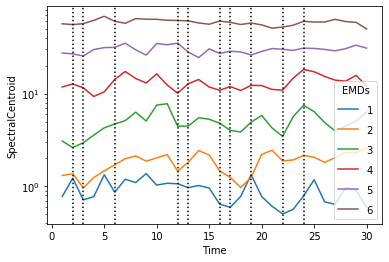

In [76]:


input_data = 'eeg'
method = 'SpectralCentroid'
#method = 'SpectralAcf'
eeg_data = epochs[condition].average('E22')
eeg_data = np.average(eeg_data.data, axis = 0)
s = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (0, +1))
if input_data == 'noise':
    seed(seed_n)
    s =  [gauss(0.0, 1.0) for i in range(len(eeg_data))]
    s = np.array(s)
    s = np.interp(s, (s.min(), s.max()), (0, +1))
eemd = EEMD()
S = s
t = np.linspace(0, 1, len(eeg_data))
# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
eIMFs = EMD().emd(s,t)
eIMFs = np.flip(eIMFs, axis =0)

eIMFs = eIMFs[3:9]
df = pd.DataFrame()
i = 0
for e in eIMFs:
    i +=1
    [f,t] = computeFeatureCl(e, method, 1000)
    #[f,t] = pyACA.computePitch(method, e, 1000, afWindow=None, iBlockLength=1000, iHopLength=100)
    df[i] = np.squeeze(f)
peaks_t = []
peaks_list = []
for t in range(len(df)):
    imf_temp = []
    for imf in range(df.shape[1]):
        imf = imf+1
        imf_temp.append(df.loc[t, imf])
    peaks_list.append(imf_temp) 
peaks_total = np.array(peaks_list) 
print('peaks shape')
print(peaks_total.shape)
cons_tot = []
peaks_cons_temp = []
for peaks in peaks_total[1:30]:

    cons, peaks_cons = compute_consonance(peaks, 0.1)
    peaks_cons_temp.append(peaks_cons)
    #print('peaks:',peaks, 'cons',cons, 'peaks_cons',peaks_cons)
xposition = []
for i in range(len(peaks_cons_temp)):
    if len(peaks_cons_temp[i]) != 0:
        xposition.append(i)
        n = n+1
ax = sbn.lineplot(data=df.loc[1:30, 0:10], dashes = False)
ax.set(xlabel='Time', ylabel=method)
ax.set_yscale('log')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'best')
#colors = ['black','black','black','black','black','black','black','black','black','black']
labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5', 'EMD6']
print(xposition)
#for xc,c, l in zip(xposition,colors, labels):
#    plt.axvline(x=xc, label='{} = {}'.format(l, xc), c=c, linestyle = 'dotted')
for xc in xposition:
    plt.axvline(x=xc, c='black', linestyle = 'dotted')
plt.show()
#plt.savefig('Spectromorph_EMD_multi-{}_{}_{}-cond-{}'.format(input_data, ch, method, condition), dpi=120)
#plt.clf()

In [52]:
xposition

[0, 4, 6, 13, 16, 21, 22, 29, 34]

In [ ]:
df

In [ ]:
a= pyACA.computeKey(eeg_data,  1000)
a

In [ ]:
[T,beats] = pyACA.computeBeatHisto(eeg_data, 1000)
plt.plot(T,np.squeeze(beats))

In [ ]:
[f,t] = computeFeatureCl(eIMFs[3], "SpectralSlope", 1024)
pitch_chroma = pd.DataFrame(f)
pitch_chroma

In [ ]:
##Plot of pitch tracking across EMDs###
df = pd.DataFrame()
i = 0
for e in eIMFs:
    i +=1
    [f, t] = pyACA.computePitch('TimeAcf', e, 1000, afWindow=None, iBlockLength=1000, iHopLength=200)
    df[i] = f

In [ ]:
import seaborn as sbn
ax = sbn.lineplot(data=df.loc[0:13, 3:6], dashes = False)
ax.set(xlabel='Time', ylabel='Pitch (SpectralAcf)')
ax.set_yscale('log')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'lower left')
#plt.savefig('EMDs_pitch_par_frontalR', dpi=120)

In [ ]:
array = ((np.array(df)).T)*100
array[4]

In [ ]:
###PLAY AUDIO#####

import math

from pyaudio import PyAudio # sudo apt-get install python{,3}-pyaudio

try:
    from itertools import izip
except ImportError: # Python 3
    izip = zip
    xrange = range

def sine_tone(frequency, duration, volume=1, sample_rate=44100):
    n_samples = int(sample_rate * duration)
    restframes = n_samples % sample_rate

    p = PyAudio()
    stream = p.open(format=p.get_format_from_width(1), # 8bit
                    channels=1, # mono
                    rate=sample_rate,
                    output=True)
    s = lambda t: volume * math.sin(2 * math.pi * frequency * t / sample_rate)
    samples = (int(s(t) * 0x7f + 0x80) for t in xrange(n_samples))
    for buf in izip(*[samples]*sample_rate): # write several samples at a time
        stream.write(bytes(bytearray(buf)))

    # fill remainder of frameset with silence
    stream.write(b'\x80' * restframes)

    stream.stop_stream()
    stream.close()
    p.terminate()

In [ ]:

for i in range(len(array[3])):
    print(array[3][i])
    sine_tone(array[3][i], 0.2, volume=0.5)
    
    #sine_tone(array[4][i], 0.2, volume=0.5)

In [ ]:
sine_tone(300, 0.5, volume=1)

In [ ]:
import operator
import scipy
peaks_EMD = []
for e in range(len(eIMFs[1 :-1])):
    freqs, psd = scipy.signal.welch(eIMFs[e], 1000, nfft = 4096, nperseg = 1024)
    index, value = max(enumerate(psd), key=operator.itemgetter(1))
    peaks_EMD.append(freqs[index])
    
peaks_EMD = np.round(peaks_EMD[1:-1], 1)

In [ ]:
peaks_EMD

In [ ]:
import scipy.signal
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
##plot PowerSpectralPlot of each EMD##
freqs, psd = scipy.signal.welch(eIMFs[3], 1000, nfft = 4096, nperseg = 512)
freqs2, psd2 = scipy.signal.welch(eIMFs[2], 1000, nfft = 4096, nperseg = 512)

plt.figure(figsize=(5, 4))
plt.plot(freqs, psd)
plt.plot(freqs, psd2)

plt.xlim([1, 60])
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}'))
plt.title('PSD of Empirical Mode Decomposition 1')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xscale('log')
plt.tight_layout()
#plt.savefig('PSD_EMD_5_delta', dpi=120)

In [ ]:
path = '../../pareidolia_run4.fif'
#path = 'C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif'
epochs = mne.read_epochs(path)
epochs2 = epochs.copy().apply_baseline((-1.5, -0.1))
epochs2 = epochs2.crop(0.5, 7.5)
epochs_filter = epochs2.filter(0.1, 100)

In [12]:
#####COMPUTE PEAKS#####

from biotuner_offline import *
par = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']
nopar = ['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
condition = par
ch = ['E22', 'E24', 'E25']
dim_reduc = 'avg' #Mode could either be 'avg' or 'mode'
precision = 0.25   #Default precision is 0.125Hz
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18],[18, 30], [30, 50]]
#peaks= compute_peaks(epochs.copy(), condition, ch, FREQ_BANDS, tmin = 0.5, tmax = 7.5, precision = precision, sf =1000)
peaks= compute_peaks_avg(epochs.copy(), condition, ch, FREQ_BANDS, dim_reduc = dim_reduc, tmin = 0.5, tmax = 7.5, precision = precision, sf =1000)
peaks

Applying baseline correction (mode: mean)
(104, 114, 7001)
7000
4000
Effective window size : 4.000 (s)
0
0
Effective window size : 4.000 (s)
11
11
Effective window size : 4.000 (s)
3
3
Effective window size : 4.000 (s)
23
19
Effective window size : 4.000 (s)
14
24
Effective window size : 4.000 (s)
6
41


array([ 1. ,  5.8,  7.8, 17.2, 22.8, 35.9])

In [ ]:
eeg_data = epochs2[condition].average('E22')
eeg_data = np.average(eeg_data.data, axis = 0)

In [ ]:
def compute_peaks_raw(eeg_data, FREQ_BANDS, sf=1000, nperseg = 1024, nfft = 4096):
    psd_all = []
    freqs_all = []
    FREQs_temp=[]
    for minf, maxf in FREQ_BANDS:
        freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg)
        psd = 10. * np.log10(psd) 
        bin_size = (sf/2)/len(freqs)
        min_index = int(minf/bin_size)+2
        max_index = int(maxf/bin_size)+2
        index_max = np.argmax(np.array(psd[min_index:max_index]))
        print(index_max)
        freq = freqs[min_index+index_max]
         #   print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
        FREQs_temp.append(freq)

    FREQS = np.array(FREQs_temp)
    return FREQS

In [ ]:
import scipy
import random
from mspacman.generator import (noise, simulate_pac)
euler_ = []
channels = epochs.ch_names
for seed_n, ch in enumerate(channels[0:20]): 
    seed_n = seed_n
    eeg_data = epochs[condition].average(ch)
    
    s = np.average(eeg_data.data, axis = 0)
    #s = [random.random() for _ in range(len(s))]
    s = noise.white(len(eeg_data))
    s = np.array(s)
    eeg_data = np.interp(s, (s.min(), s.max()), (0, +1))
    freqs = compute_peaks_raw(eeg_data, FREQ_BANDS)
    peaks_euler = [int(x*10) for x in freqs]
    euler_temp = euler(peaks_euler[0], peaks_euler[1], peaks_euler[2], peaks_euler[3], peaks_euler[4])
    euler_.append(euler_temp)
euler_all_noise_white = np.array(euler_)


In [ ]:
import mspacman

In [ ]:
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 30], [30, 45], [45, 60]]
freqs = compute_peaks_raw(eeg_data, FREQ_BANDS, nperseg = 1024, nfft = 2048)
freqs

In [ ]:
variable = euler_all4
plt.hist(variable, bins = 400)
np.mean(variable)

In [ ]:
plt.plot(freqs[0:120], psd[0:120])

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelmin

import dissonant as D

## Phase-Amplitude Coupling

In [ ]:
####PAC###
import numpy as np
import matplotlib.pyplot as plt

from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac

In [ ]:
drive_steps = 50
max_drive_freq = 12
low_fq_range = np.linspace(1, max_drive_freq, drive_steps)
methods = ['penny']
    #'ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    #'sigl', 'bispectrum'
#]


eeg_data = epochs2[nopar].average('E69')
eeg_data = np.average(eeg_data.data, axis = 0)


In [ ]:
fs = 1000
signal = eeg_data
low_fq_width = 0.5  # Hz

In [ ]:
n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))
fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
axs = axs.ravel()
plt.ylim(0, 50)

# Compute the comodulograms and plot them
for ax, method in zip(axs, methods):
    print('%s... ' % (method, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signal)
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])

plt.show()



In [ ]:
estimator.comod_.shape

In [ ]:
freq_limits = [[3, 10], [20, 45]]
#estimator.comod_[][4]
pac_data = estimator.comod_
drive_min = int(freq_limits[0][0]/(max_drive_freq/drive_steps))
drive_max = int(freq_limits[0][1]/(max_drive_freq/drive_steps))
signal_min = int(freq_limits[1][0]/((fs/2)/len(pac_data[0])))

signal_max = int(freq_limits[1][1]/((fs/2)/len(pac_data[0])))
new_pac = pac_data[drive_min:drive_max, signal_min:signal_max]
print(new_pac.shape)
limit_value = np.quantile(new_pac, 0.95)
pac_high = []

for d in range(len(pac_data)):
    for s in range(len(pac_data[0])):
        temp_ = pac_data[d][s]
        if temp_ > limit_value:
            d_freq = d*(max_drive_freq/drive_steps)
            s_freq = s*((fs/2)/len(pac_data[0]))
            if d_freq >= freq_limits[0][0] and d_freq <= freq_limits[0][1] and s_freq >= freq_limits[1][0] and s_freq <= freq_limits[1][1]:           #print(driver_freq)
                pac_high.append((d_freq, s_freq))



In [ ]:
pac_high

In [ ]:

#estimator.comod_[][4]
pac_data = estimator.comod_
limit_value = np.quantile(new_pac, 0.99)
pac_high = []

for d in range(len(pac_data)):
    for s in range(len(pac_data[0])):
        temp_ = pac_data[d][s]
        if temp_ > limit_value:
            print('got it')
            d_freq = d*(max_drive_freq/drive_steps)
            s_freq = s*((fs/2)/len(pac_data[0]))
            if d_freq > 2.5 and s_freq > 30 and s_freq < 60:
            #print(driver_freq)
                pac_high.append((d_freq, s_freq))

In [ ]:
pac_data.shape

In [ ]:
from pactools import PeakLocking
fs = 1000  # Hz
low_fq = 3.5  # Hz
t_plot = 2.0  # sec
estimator = PeakLocking(fs=fs, low_fq=low_fq, low_fq_width=2.0, t_plot=t_plot)
estimator.fit(signal)
estimator.plot()

estimator = PeakLocking(fs=fs, low_fq=low_fq, low_fq_width=0.5, t_plot=t_plot)
estimator.fit(signal)
estimator.plot()

plt.show()

## Dissonance curve

In [ ]:

def freq_space(base_f=440, octaves=4, steps=1000):
    ratios = np.linspace(1, octaves, steps)
    freqs = base_f * ratios
    return freqs

def dissonance_curve(freq_space, n_partials=10, model='sethares1993'):
    dissonances = []
    for freq in freq_space:
        h_freqs, h_amps = D.harmonic_tone([freq_space[0], freq], n_partials=n_partials)
        d = D.dissonance(h_freqs, h_amps, model=model)
        dissonances.append(d)
    dissonances = np.array(dissonances)
    return dissonances

def plot_dissonance_curve(freqs, dissonances):
    minima = argrelmin(dissonances)[0]

    plt.figure(figsize=(16, 3))
    plt.xlim(freqs[0], freqs[-1])
    plt.plot(freqs, dissonances)
    for m in minima:
        plt.axvline(freqs[m], c='r', ls=':')
    plt.xlabel('frequency')
    plt.ylabel('dissonance')

In [ ]:
freqs = [x*10 for x in freqs]
plot_dissonance_curve(freqs, dissonance_curve(freqs, n_partials=100, model='sethares1993'))

In [ ]:
from fractions import Fraction
from math import log
from functools import reduce
def gcd(*numbers):
    """
    Return the greatest common divisor of the given integers
    The result will have the same sign as the last number given (so that
    when the last number is divided by the result, the result comes out
    positive).
    """
    def gcd(a, b):
        while b:
            a, b = b, a % b
        return a

    return reduce(gcd, numbers)
def reduced_form(*numbers):
    """
    Return a tuple of numbers which is the reduced form of the input,
    which is a list of integers
    """
    return tuple(int(a // gcd(*numbers)) for a in numbers)
def lcm(*numbers):
    """
    Return the least common multiple of the given integers
    """
    def lcm(a, b):
        if a == b == 0:
            return 0
        return (a * b) // gcd(a, b)

    # LCM(a, b, c, d) = LCM(a, LCM(b, LCM(c, d)))
    return reduce(lcm, numbers)
def prime_factors(n):
    """
    Return a list of the prime factors of the integer n.
    Don't use this for big numbers; it's a dumb brute-force method.
    """
    factors = []
    lastresult = n

    while lastresult > 1:
        c = 2
        while lastresult % c > 0:
            c += 1
        factors.append(c)
        lastresult /= c

    return factors
def euler(*numbers):
    """
    Euler's "gradus suavitatis" (degree of sweetness) function
    Return the "degree of sweetness" of a musical interval or chord expressed
    as a ratio of frequencies a:b:c, according to Euler's formula
    Greater values indicate more dissonance
    """
    factors = prime_factors(lcm(*reduced_form(*numbers)))
    return 1 + sum(p - 1 for p in factors)

In [ ]:
##Multiple PSD##
from PyEMD import EMD, EEMD
import numpy as np
import operator
import scipy
par = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']
nopar = ['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
conditions = [par, nopar]
path = '../../pareidolia_run2.fif'


def EMD_PSD_graph(path, spectro='Euler', bands = 0, xmin=1, xmax=70, plot_type = 'stackplot', compare = True, input_data= 'EEG'):
    
    import random
    if bands == 0:
        bands = [[0, 3], [3, 7], [7, 12], [12, 30], [30, 70]]
    
    epochs = mne.read_epochs(path)
    epochs = epochs.apply_baseline((-1.5, -0.1))
    epochs = epochs.crop(0.5, 7.5)
    channels = epochs.ch_names
    percentage_fit = []
    euler_all = []
    for condition in conditions:
        i = 0
        for seed_n, ch in enumerate(channels): 
            eeg_data = epochs[condition].average(ch)
            eeg_data = np.average(eeg_data.data, axis = 0)
            
            s = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (0, +1))
            eemd = EEMD()
            if input_data == 'noise':
                seed(seed_n)
                #s =  [gauss(0.0, 1.0) for i in range(len(eeg_data))]
                s = [random.random() for _ in range(len(eeg_data))]
                s = noise.white(len(eeg_data))
                s = np.array(s)
                s = np.interp(s, (s.min(), s.max()), (0, +1))
                
            _data = s.copy()
            t = np.linspace(0, 1, len(eeg_data))
            # Say we want detect extrema using parabolic method
            emd = eemd.EMD
            emd.extrema_detection="parabol"
            eIMFs = EMD().emd(s,t)
            eIMFs = np.flip(eIMFs, axis =0)
            peaks_EMD = []
            for e in range(len(eIMFs[:])):
                freqs, psd = scipy.signal.welch(eIMFs[e], 1000, nfft = 4096, nperseg = 1024)
                index, value = max(enumerate(psd), key=operator.itemgetter(1))
                peaks_EMD.append(freqs[index])
            peaks_EMD = np.round(peaks_EMD[:], 1)

            print(peaks_EMD)

            for e, p in enumerate(peaks_EMD):
                if p > 3 and p<7 and peaks_EMD[e-1]<3:
                    index_start = e-1
            if peaks_EMD[index_start+4]<30:
                index_start = index_start +1
            if peaks_EMD[index_start+4]>90:
                index_start = index_start-1
            peaks_EMD = peaks_EMD[index_start:index_start+5]
            eIMFs = eIMFs[index_start:index_start+5]
            freqs_all = []
            psd_all = []
            for e in range(len(eIMFs)):
                freqs, psd = scipy.signal.welch(eIMFs[e], 1000, nfft = 4096, nperseg = 1024)
                freqs_all.append(freqs)
                psd_all.append(psd)
            freqs_all = np.array(freqs_all)
            psd_all = np.array(psd_all)
            # Stackplot with X, Y, colors value 
            
            
            if plot_type == 'line':
                color_line = ['aqua', 'darkturquoise', 'darkcyan', 'darkslategrey', 'black']
                plt.plot(freqs, psd_all[0], color = color_line[0])
                plt.plot(freqs, psd_all[1], color = color_line[1])
                plt.plot(freqs, psd_all[2], color = color_line[2])
                plt.plot(freqs, psd_all[3], color = color_line[3])
                plt.plot(freqs, psd_all[4], color = color_line[4])
                color1 = 'midnightblue'
                color2 = 'turquoise'
                colors = ['darkgoldenrod', 'goldenrod', 'orange', 'gold', 'khaki']
                color_bg = ['darkgoldenrod', 'goldenrod', 'orange', 'gold', 'khaki']
                #color_bg = ['paleturquoise', 'aqua', 'darkturquoise','darkcyan' , 'darkslategrey']
                alpha = [0.6, 0.63, 0.66, 0.69, 0.72]
                shadow=0.9
                if compare==True:
                    freqs_full, psd_full = scipy.signal.welch(_data, 1000, nfft = 4096, nperseg = 1024)
                    psd_full = np.interp(psd_full, (psd_full.min(), psd_full.max()), (0, 0.005))
                    plt.plot(freqs, psd_full, color = 'deeppink', linestyle='dashed')
                plt.text(1.7, 0.0028, 'delta', horizontalalignment = 'center')
                plt.text(4.5, 0.0028, 'theta', horizontalalignment = 'center')
                plt.text(9, 0.0028, 'alpha', horizontalalignment = 'center')
                plt.text(19, 0.0028, 'beta', horizontalalignment = 'center')
                plt.text(47, 0.0028, 'gamma', horizontalalignment = 'center')
            if plot_type == 'stackplot':
                pal = sbn.color_palette("YlOrBr")
                plt.stackplot(freqs, psd_all[0], psd_all[1],psd_all[2], psd_all[3], psd_all[4],
                          colors =pal)
                colors = ['darkslategrey', 'darkcyan', 'darkturquoise', 'aqua', 'paleturquoise']
                color_bg = ['navy', 'darkred', 'navy', 'darkred', 'navy']
                alpha = [0.2, 0.35, 0.5, 0.65, 0.80]
                shadow = 0.9
            plt.xlim([xmin, xmax])
            plt.ylim([0.000001, 0.005])
            #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}'))
            plt.title('PSD of Empirical Mode Decomposition 1 to 5; ch:{}'.format(ch))
            plt.xlabel('Frequency')
            plt.ylabel('Power')
            plt.yscale('log')
            plt.xscale('log')

            xposition = peaks_EMD

            labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5']
            for p, n, band in zip(peaks_EMD, range(len(labels)), bands):
                print(band[0])
                print(band[1])
                print(p)
                
                if p > band[0] and p<= band[1]:
                    print('got it')
                    labels[n] = labels[n]+'*'
                    i = i+1
            
            print(labels)
            for xc,c, l in zip(xposition,color_line, labels):
                plt.axvline(x=xc, label='{} = {}'.format(l, xc), c=c)
            plt.axvspan(0, 3, ymin = shadow, alpha=alpha[0], color=color_bg[0], ec ='black')
            plt.axvspan(3, 7, ymin = shadow, alpha=alpha[1], color=color_bg[1],ec ='black')
            plt.axvspan(7, 12, ymin = shadow, alpha=alpha[2], color=color_bg[2], ec ='black')
            plt.axvspan(12, 30, ymin = shadow, alpha=alpha[3], color=color_bg[3], ec ='black')
            plt.axvspan(30, 70, ymin = shadow, alpha=alpha[4], color=color_bg[4], ec ='black')
            
            plt.legend(loc='lower left')
            #plt.show()

            #plt.tight_layout()
            if spectro == 'Euler':
                peaks_euler = [int(x*100) for x in peaks_EMD]
                euler_temp = euler(peaks_euler[0], peaks_euler[1], peaks_euler[2], peaks_euler[3], peaks_euler[4])
                euler_all.append(euler_temp)

                
                print(euler_temp)
                plt.text(45, 0.001, 'Euler = '+str(int(euler_temp)), horizontalalignment = 'center')
                
            
            plt.savefig('PSD_EMD_multi_{}_{}_cond-{}_{}'.format(plot_type, ch, condition, spectro), dpi=120)
            plt.clf()
        percentage_fit.append((i/(len(epochs.ch_names)*5))*100)
    percentage_fit = np.array(percentage_fit)
    euler_output = np.array(euler_all)
    return percentage_fit, euler_output
    
 

In [ ]:
epochs = mne.read_epochs(path)
epochs = epochs.apply_baseline((-1.5, -0.1))
epochs = epochs.crop(0.5, 7.5)

(9501,)
[  1.    1.    1.    1.    2.    4.4  10.   26.9  50.3 112.5]
['EMD1*', 'EMD2*', 'EMD3*', 'EMD4*', 'EMD5*']


NameError: name 'euler' is not defined

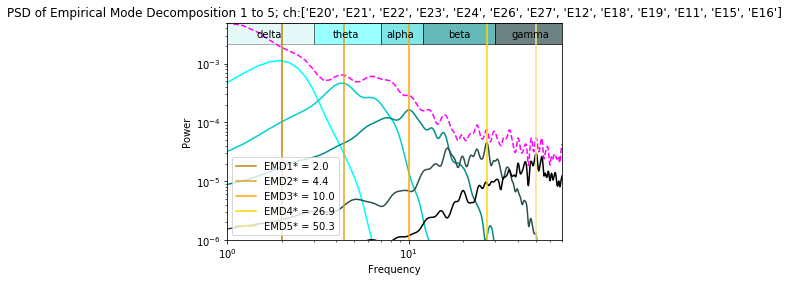

In [49]:
from PyEMD import EMD, EEMD
import numpy as np
import operator
import scipy


plot_type = 'line'
xmin=1
xmax=70
bands = [[0, 3], [3, 7], [7, 12], [12, 30], [30, 70]]
compare=True
ch = frontal_L
spectro = 'Euler'
condition = par


eeg_data = epochs[condition].average(ch)
eeg_data = np.average(eeg_data.data, axis = 0)
print(eeg_data.shape)
s = np.interp(eeg_data, (eeg_data.min(), eeg_data.max()), (0, +1))
eemd = EEMD()
S = s
t = np.linspace(0, 1, 9501)
# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
eIMFs = EMD().emd(s,t)
eIMFs = np.flip(eIMFs, axis =0)
peaks_EMD = []
for e in range(len(eIMFs[:])):
    freqs, psd = scipy.signal.welch(eIMFs[e], 1000, nfft = 4096, nperseg = 1024)
    index, value = max(enumerate(psd), key=operator.itemgetter(1))
    peaks_EMD.append(freqs[index])
peaks_EMD = np.round(peaks_EMD[:], 1)

print(peaks_EMD)

for e, p in enumerate(peaks_EMD):
    if p > 3 and p<7 and peaks_EMD[e-1]<3:
        index_start = e-1
if peaks_EMD[index_start+4]<30:
    index_start = index_start +1
if peaks_EMD[index_start+4]>90:
    index_start = index_start-1
peaks_EMD = peaks_EMD[index_start:index_start+5]
eIMFs = eIMFs[index_start:index_start+5]
freqs_all = []
psd_all = []
for e in range(len(eIMFs)):
    freqs, psd = scipy.signal.welch(eIMFs[e], 1000, nfft = 4096, nperseg = 1024)
    freqs_all.append(freqs)
    psd_all.append(psd)
freqs_all = np.array(freqs_all)
psd_all = np.array(psd_all)
# Stackplot with X, Y, colors value 


if plot_type == 'line':
    plt.plot(freqs, psd_all[0], color = 'aqua')
    plt.plot(freqs, psd_all[1], color = 'darkturquoise')
    plt.plot(freqs, psd_all[2], color = 'darkcyan')
    plt.plot(freqs, psd_all[3], color = 'darkslategrey')
    plt.plot(freqs, psd_all[4], color = 'black')
    
    if compare==True:
        freqs_full, psd_full = scipy.signal.welch(eeg_data, 1000, nfft = 4096, nperseg = 1024)
        psd_full = np.interp(psd_full, (psd_full.min(), psd_full.max()), (0, 0.005))
        plt.plot(freqs, psd_full, color = 'magenta', linestyle='dashed')
        l
    
    color1 = 'turquoise'
    color2 = 'indigo'
    colors = ['darkgoldenrod', 'goldenrod', 'orange', 'gold', 'khaki']
    color_bg = ['paleturquoise', 'aqua', 'darkturquoise','darkcyan' , 'darkslategrey']
    alpha = [0.3, 0.4, 0.5, 0.6, 0.7]
    shadow=0.9
if plot_type == 'stackplot':
    pal = sbn.color_palette("YlOrBr")
    plt.stackplot(freqs, psd_all[0], psd_all[1],psd_all[2], psd_all[3], psd_all[4],
              colors =pal)
    colors = ['darkslategrey', 'darkcyan', 'darkturquoise', 'aqua', 'paleturquoise']
    color_bg = ['navy', 'darkred', 'navy', 'darkred', 'navy']
    alpha = [0.2, 0.35, 0.5, 0.65, 0.80]
    shadow = 0.9
plt.xlim([xmin, xmax])
plt.ylim([0.000001, 0.005])
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}'))
plt.title('PSD of Empirical Mode Decomposition 1 to 5; ch:{}'.format(ch))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.yscale('log')
plt.xscale('log')

xposition = peaks_EMD

labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5']
for p, n, band in zip(peaks_EMD, range(len(labels)), bands):
    #print(band[0])
    #print(band[1])
    #print(p)

    if p > band[0] and p<= band[1]:
        #print('got it')
        labels[n] = labels[n]+'*'
        #i = i+1

print(labels)
for xc,c, l in zip(xposition,colors, labels):
    plt.axvline(x=xc, label='{} = {}'.format(l, xc), c=c)
plt.axvspan(0, 3, ymin = shadow, alpha=alpha[0], color=color_bg[0], ec ='black')
plt.text(1.7, 0.0028, 'delta', horizontalalignment = 'center')
plt.text(4.5, 0.0028, 'theta', horizontalalignment = 'center')
plt.text(9, 0.0028, 'alpha', horizontalalignment = 'center')
plt.text(19, 0.0028, 'beta', horizontalalignment = 'center')
plt.text(47, 0.0028, 'gamma', horizontalalignment = 'center')
plt.axvspan(3, 7, ymin = shadow, alpha=alpha[1], color=color_bg[1],ec ='black')
plt.axvspan(7, 12, ymin = shadow, alpha=alpha[2], color=color_bg[2], ec ='black')
plt.axvspan(12, 30, ymin = shadow, alpha=alpha[3], color=color_bg[3], ec ='black')
plt.axvspan(30, 70, ymin = shadow, alpha=alpha[4], color=color_bg[4], ec ='black')
plt.legend(loc='lower left')
euler_all = []
if spectro == 'Euler':
    peaks_euler = [int(x*100) for x in peaks_EMD]
    euler_temp = euler(peaks_euler[0], peaks_euler[1], peaks_euler[2], peaks_euler[3], peaks_euler[4])
    euler_all.append(euler_temp)

    euler_final = np.array(euler_all)
    print(euler_final)
    plt.text(45, 0.001, 'Euler = '+str(int(euler_final)), horizontalalignment = 'center')
plt.show()

#plt.tight_layout()

#plt.savefig('PSD_EMD_multi_{}_{}_cond-{}'.format(plot_type, ch, condition), dpi=120)

In [ ]:

scores_noise, euler_cons_noise = EMD_PSD_graph(path, spectro = 'Euler', plot_type = 'line', input_data = 'noise')

In [ ]:
scores, euler_cons = EMD_PSD_graph(path, spectro = 'Euler', plot_type = 'line')

In [ ]:
np.mean(euler_cons_noise)

In [ ]:
[f, t] = pyACA.computePitch('TimeAcf', eIMFs[3], 1000, afWindow=None, iBlockLength=512, iHopLength=256)
plt.plot(np.squeeze(f))

In [ ]:
peaks_EMD = []
for e in range(len(eIMFs[1 :-2])):
    freqs, psd = scipy.signal.welch(eIMFs[e], 1000, nfft = 4096, nperseg = 1024)
    index, value = max(enumerate(psd), key=operator.itemgetter(1))
    peaks_EMD.append(freqs[index])
    
peaks_EMD = np.round(peaks_EMD[1:-1], 1)
np.flip(peaks_EMD)

In [ ]:
eIMFs[3] = np.interp(eIMFs[3], (eIMFs[3].min(), eIMFs[3].max()), (-1, 1))

In [ ]:
eIMFs.shape
IMF0 = eIMFs[0][0:6000]
IMF1 = eIMFs[1][0:6000]
IMF2 = eIMFs[2][0:6000]
IMF3 = eIMFs[3][0:6000]
IMF4 = eIMFs[4][0:6000]
IMF5 = eIMFs[5][0:6000]
IMF6 = eIMFs[6][0:6000]
IMF7 = eIMFs[7][0:6000]
IMF8 = eIMFs[8][0:6000]
#IMF9 = eIMFs[9][0:6000]